Download McQuillan catalog

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stardate as sd
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [8]:
mc = pd.read_csv("single_MS_stars.csv")

Download Gaia catalog

In [9]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data)

mini_gaia = pd.DataFrame(dict({"source_id": gaia.source_id,
                               "kepid": gaia.kepid,
                               "ra": gaia.ra, "ra_error": gaia.ra_error,
                               "dec": gaia.dec, "dec_error": gaia.dec_error,
                               "parallax": gaia.parallax,
                               "parallax_error": gaia.parallax_error,
                               "pmra": gaia.pmra, "pmra_error": gaia.pmra_error,
                               "pmdec": gaia.pmdec, "pmdec_error": gaia.pmdec_error,
                               "ra_dec_corr": gaia.ra_dec_corr,
                               "ra_parallax_corr": gaia.ra_parallax_corr,
                               "ra_pmra_corr": gaia.ra_pmra_corr,
                               "ra_pmdec_corr": gaia.ra_pmdec_corr,
                               "dec_parallax_corr": gaia.dec_parallax_corr,
                               "dec_pmra_corr": gaia.dec_pmra_corr,
                               "dec_pmdec_corr": gaia.dec_pmdec_corr,
                               "parallax_pmra_corr": gaia.parallax_pmra_corr,
                               "parallax_pmdec_corr": gaia.parallax_pmdec_corr,
                               "pmra_pmdec_corr": gaia.pmra_pmdec_corr,
                               "radial_velocity": gaia.radial_velocity,
                               "radial_velocity_error": gaia.radial_velocity_error,
                               "G": gaia.phot_g_mean_mag,
                               "bp": gaia.phot_bp_mean_mag,
                               "rp": gaia.phot_rp_mean_mag,
                               "jmag": gaia.jmag,
                               "hmag": gaia.hmag,
                               "kmag": gaia.kmag
                              }))

In [10]:
gaia_mc = pd.merge(mc, mini_gaia, left_on="KID", right_on="kepid", how="inner")
print(np.shape(mc), np.shape(mini_gaia), np.shape(gaia_mc))

(18259, 37) (197090, 30) (18347, 67)


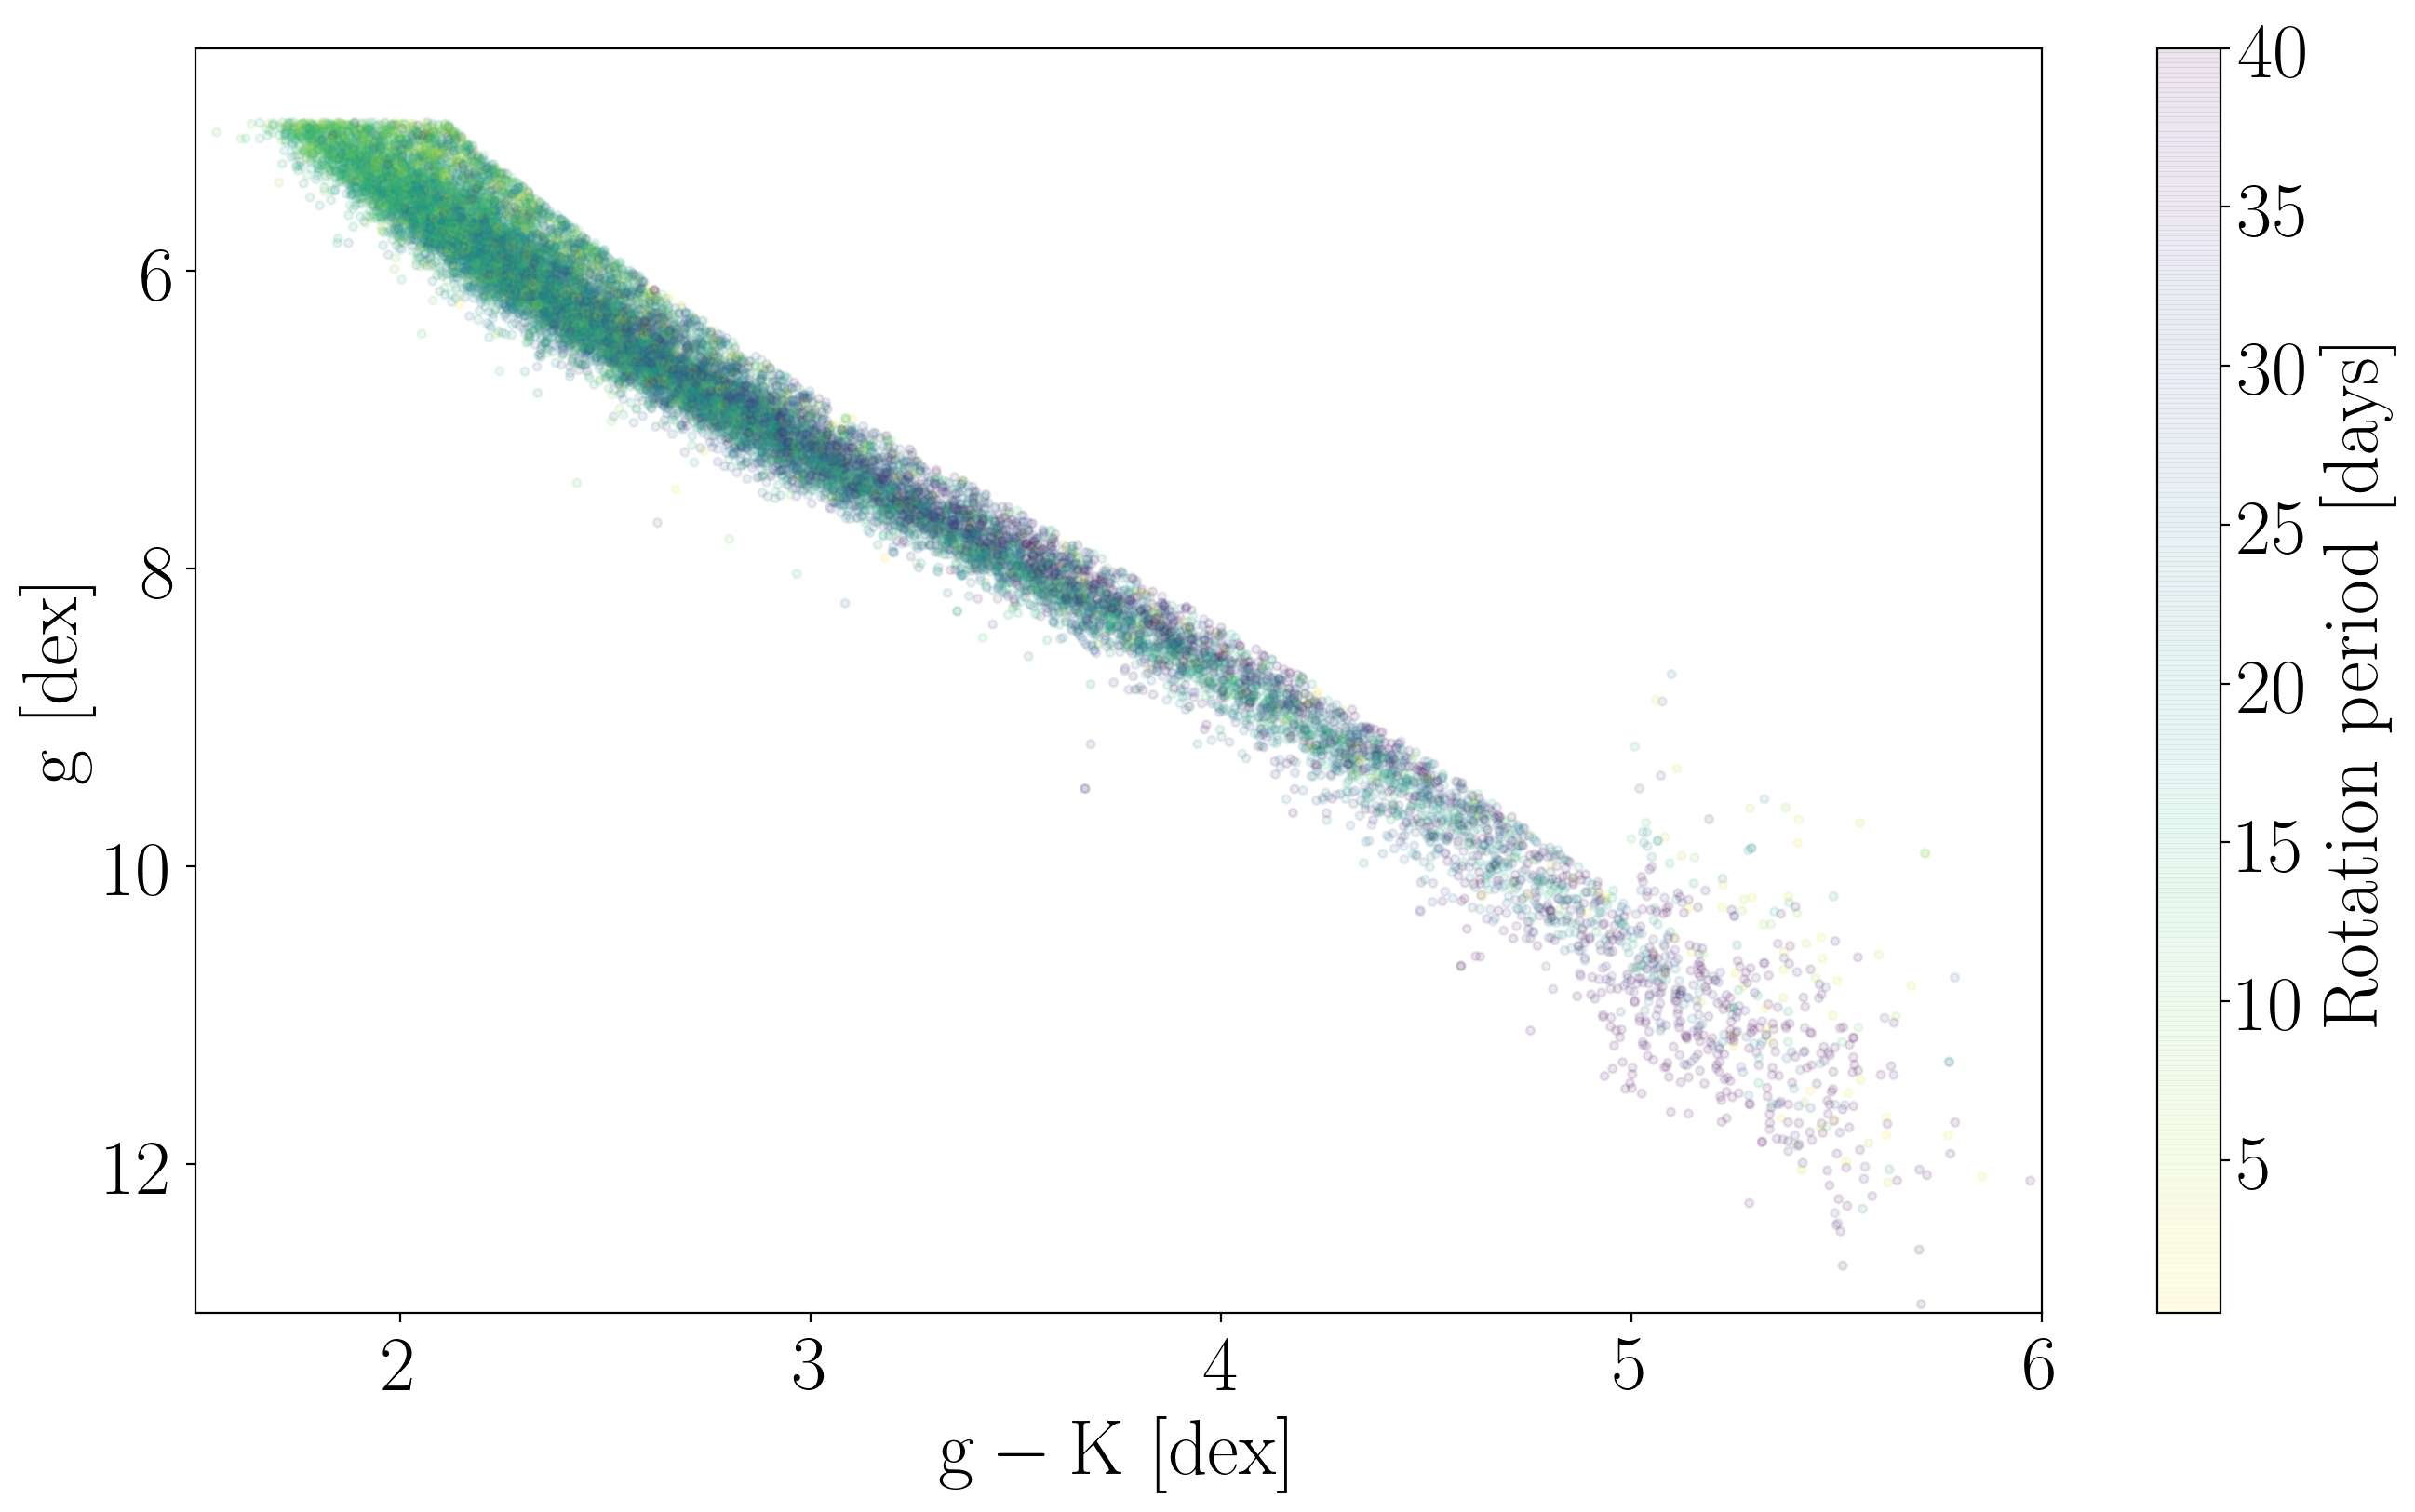

In [11]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gaia_mc.g_final - gaia_mc.Kmag, gaia_mc.abs_g,
            c=gaia_mc.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, zorder=1)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 4.5)
plt.xlim(1.5, 6);

Calculate ages

In [133]:
from stardate.lhf import age_model

logages = []
for i, p in enumerate(gaia_mc.Prot.values):
    logages.append(age_model(np.log10(p), gaia_mc.bp.values[i] - gaia_mc.rp.values[i]))

gaia_mc["log_age"] = np.array(logages)
gaia_mc["age"] = (10**np.array(logages))*1e-9

In [134]:
mrv = gaia_mc.radial_velocity.values != 0.00
print(len(gaia_mc.radial_velocity[mrv]), "stars in McQuillan with Gaia RVs")
df = gaia_mc.iloc[mrv]

998 stars in McQuillan with Gaia RVs


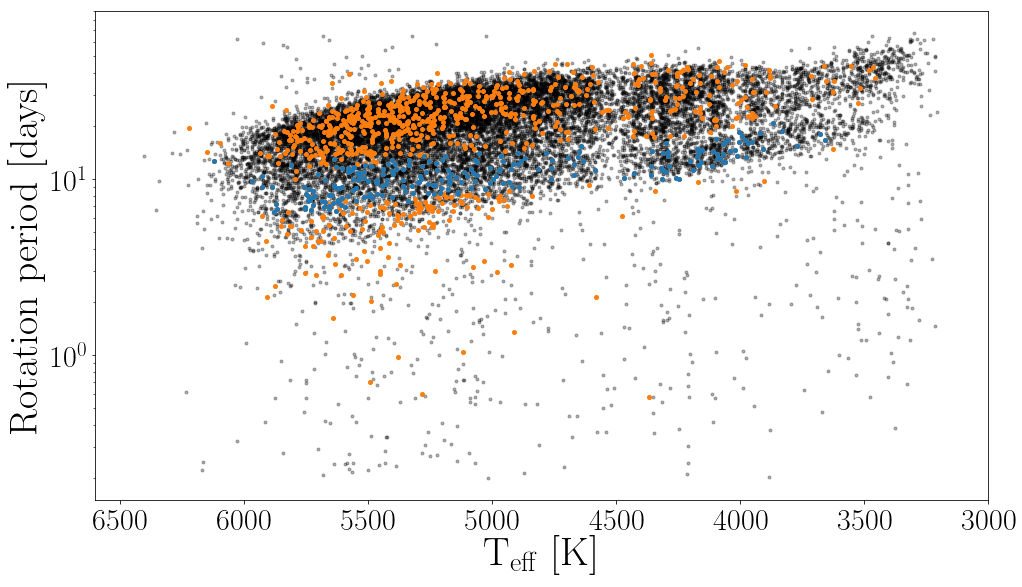

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 25,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

m = (df.age.values > .5) * (df.age.values < 1.1)

plt.figure(figsize=(16, 9))
plt.plot(mc.Teff, mc.Prot, "k.", alpha=.3, zorder=0)
plt.plot(df.Teff, df.Prot, ".", color="C1", alpha=.99, ms=8, zorder=1)
plt.plot(df.Teff[m], df.Prot[m], ".", color="C0", alpha=.99, ms=8, zorder=1)
plt.xlim(6600, 3000)
plt.yscale("log")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

In [46]:
m = df.Teff.values < 5000
# m &= df.Prot.values >= 10

cool = df.iloc[m]

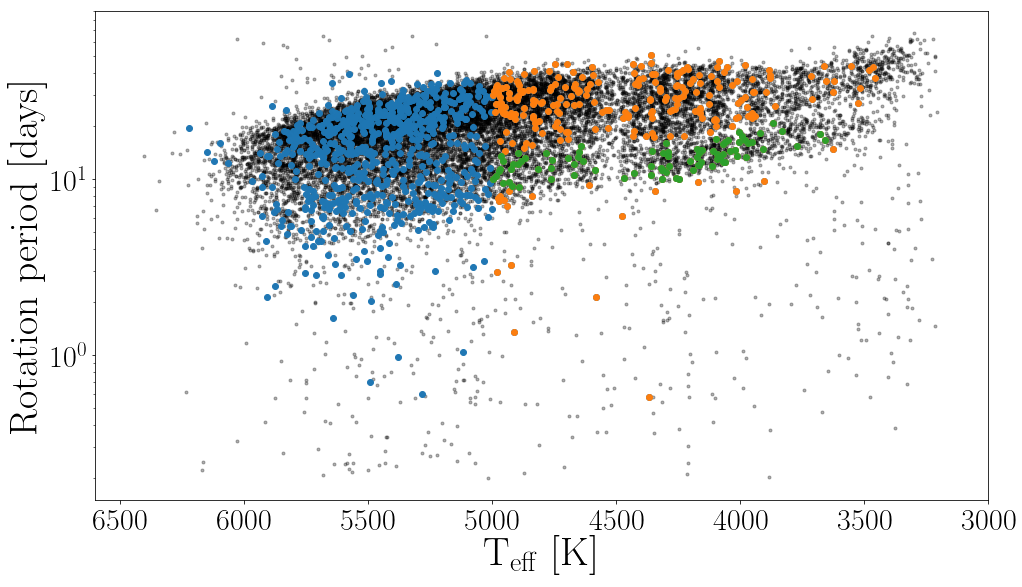

In [47]:
age_bracket = (cool.age.values > .5) * (cool.age.values < 1.1)

plt.figure(figsize=(16, 9))
plt.plot(mc.Teff, mc.Prot, "k.", alpha=.3, zorder=0)
plt.plot(df.Teff, df.Prot, ".", color="C0", alpha=.99, ms=12, zorder=1)
plt.plot(cool.Teff, cool.Prot, ".", color="C1", alpha=.99, ms=12, zorder=1)
plt.plot(cool.Teff[age_bracket], cool.Prot[age_bracket], ".", color="C2", alpha=.99, ms=12, zorder=1)

xs = np.linspace(3500, 5000, 100)
# plt.plot(xs, 51 + xs*-.008)
plt.xlim(6600, 3000)
plt.yscale("log")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

Calculate actions for these stars.

In [48]:
def action_with_err(ra_dec, dec_deg, parallax_mas, pmra_masyr, pmdec_masyr, rv_kms, rv_err, cov):
    """
    Calculate actions with uncertainties, given a covariance matrix.
    
    Args:
        ra_deg
        dec_deg
        parallax_mas
        pmra_masyr
        pmdec_masyr
        rv_kms
        rv_err
        cov
        
    cov = [[ra_err**2        ra_dec_corr       ra_parallax_corr    ra_pmra_corr       ra_pmdec_corr]
           [ra_dec_corr      dec_err**2        dec_parallax_corr   dec_pmra_corr      dec_pmdec_corr]
           [ra_parallax_corr dec_parallax_corr parallax_err**2     parallax_pmra_corr parallax_pmdec_corr]
           [ra_pmra_corr     dec_pmra_corr     parallax_pmra_corr  pmra_err**2        pmra_pmdec_corr]
           [ra_pmdec_corr    dec_pmdec_corr    parallax_pmdec_corr pmra_pmdec_corr    pmdec_err**2]]
    """
    
    

Calculate actions.

In [49]:
import actions as ac
from tqdm import trange

jz = np.ones(len(cool.ra.values))
for i in trange(len(cool.ra.values)):
    try:
        R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, Lz, Jz = ac.action(
            cool.ra.values[i], cool.dec.values[i], 1./cool.parallax.values[i], 
            cool.pmra.values[i], cool.pmdec.values[i], cool.radial_velocity.values[i])
        jz[i] = Jz
    except:
        UnboundError
        jz[i] = np.nan

cool["jz"] = jz

100%|██████████| 320/320 [00:16<00:00, 19.68it/s]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app



Calculate velocities.

In [225]:
import astropy.units as u
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic

m = gaia_mc.Teff.values < 4800 
gaia_mc_cool = gaia_mc.iloc[m]
gaia_mc_hot = gaia_mc.iloc[~m]

i = 0
icrs = ICRS(ra=gaia_mc_cool.ra.values*u.degree,
            dec=gaia_mc_cool.dec.values*u.degree,
            pm_ra_cosdec=gaia_mc_cool.pmra.values*u.mas/u.yr,
            pm_dec=gaia_mc_cool.pmdec.values*u.mas/u.yr)
vels = icrs.transform_to(Galactic)
vels.pm_b
pm_b = np.array(vels.pm_b.value)
gaia_mc_cool["pm_b"] = pm_b

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



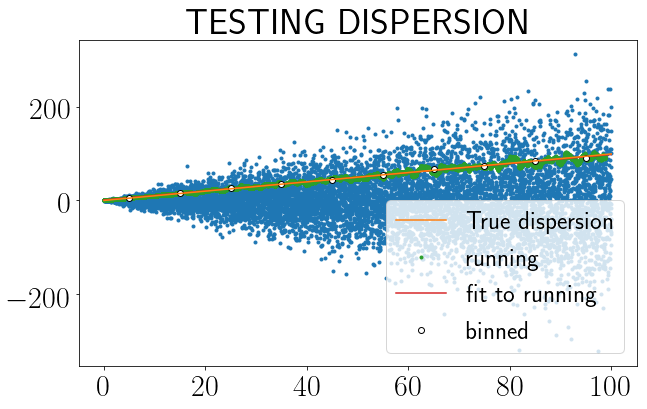

In [176]:
def running_dispersion(x, y, bsize, mad=False):
    
    assert x[0] == np.sort(x)[0], "arrays must be sorted on x."
    
    # Calculate running std of points in bin of bsize
    d, newx = [], []
    for i in range(len(x)):
        if i+bsize < len(x):
            if not mad:
                d.append(np.std(y[i:i + bsize]))
            else:
                d.append(np.median(np.abs(y[i:i + bsize])))
            newx.append(x[i])
    
    return np.array(newx), np.array(d)

def binned_dispersion(x, y, nbins, mad=False):
    
    d, N = [np.zeros(nbins) for i in range(2)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width
    
    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        if not mad:
            d[i] = np.std(y[m])
        else:
#             d[i] = np.median(np.abs(y[m]))
            d[i] = np.sqrt(np.median(y[m]))
        N[i] = sum(m)
    return mid_bin, d, d/np.sqrt(N)

np.random.seed(42)
N = 10000
x = np.random.uniform(0, 100, N)
y = np.random.randn(N)*x
inds = np.argsort(x)
x, y = x[inds], y[inds]

plt.figure(figsize=(10, 6))
plt.plot(x, y, ".")
plt.plot(x, x, zorder=3, label="True dispersion")

newx, d = running_dispersion(x, y, 100, mad=False)
plt.plot(newx, d, ".", label="running")

AT = np.vstack((newx, np.ones_like(newx)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, d))
plt.plot(x, w[0]*x + w[1], label="fit to running")
plt.title("TESTING DISPERSION")

bins, dbins, err = binned_dispersion(x, y, 10, mad=False)
plt.errorbar(bins, dbins, yerr=err, fmt="wo", markeredgecolor="k", label="binned")

plt.legend()

assert np.isclose(w[0], 1, atol=.1)

In [177]:
# def betterstep(bins, y, **kwargs):
#     new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
#     new_y = [a for row in zip(y, y) for a in row]
#     ax = kwargs.pop("ax", plt.gca())
#     return ax.plot(new_x, new_y, **kwargs)

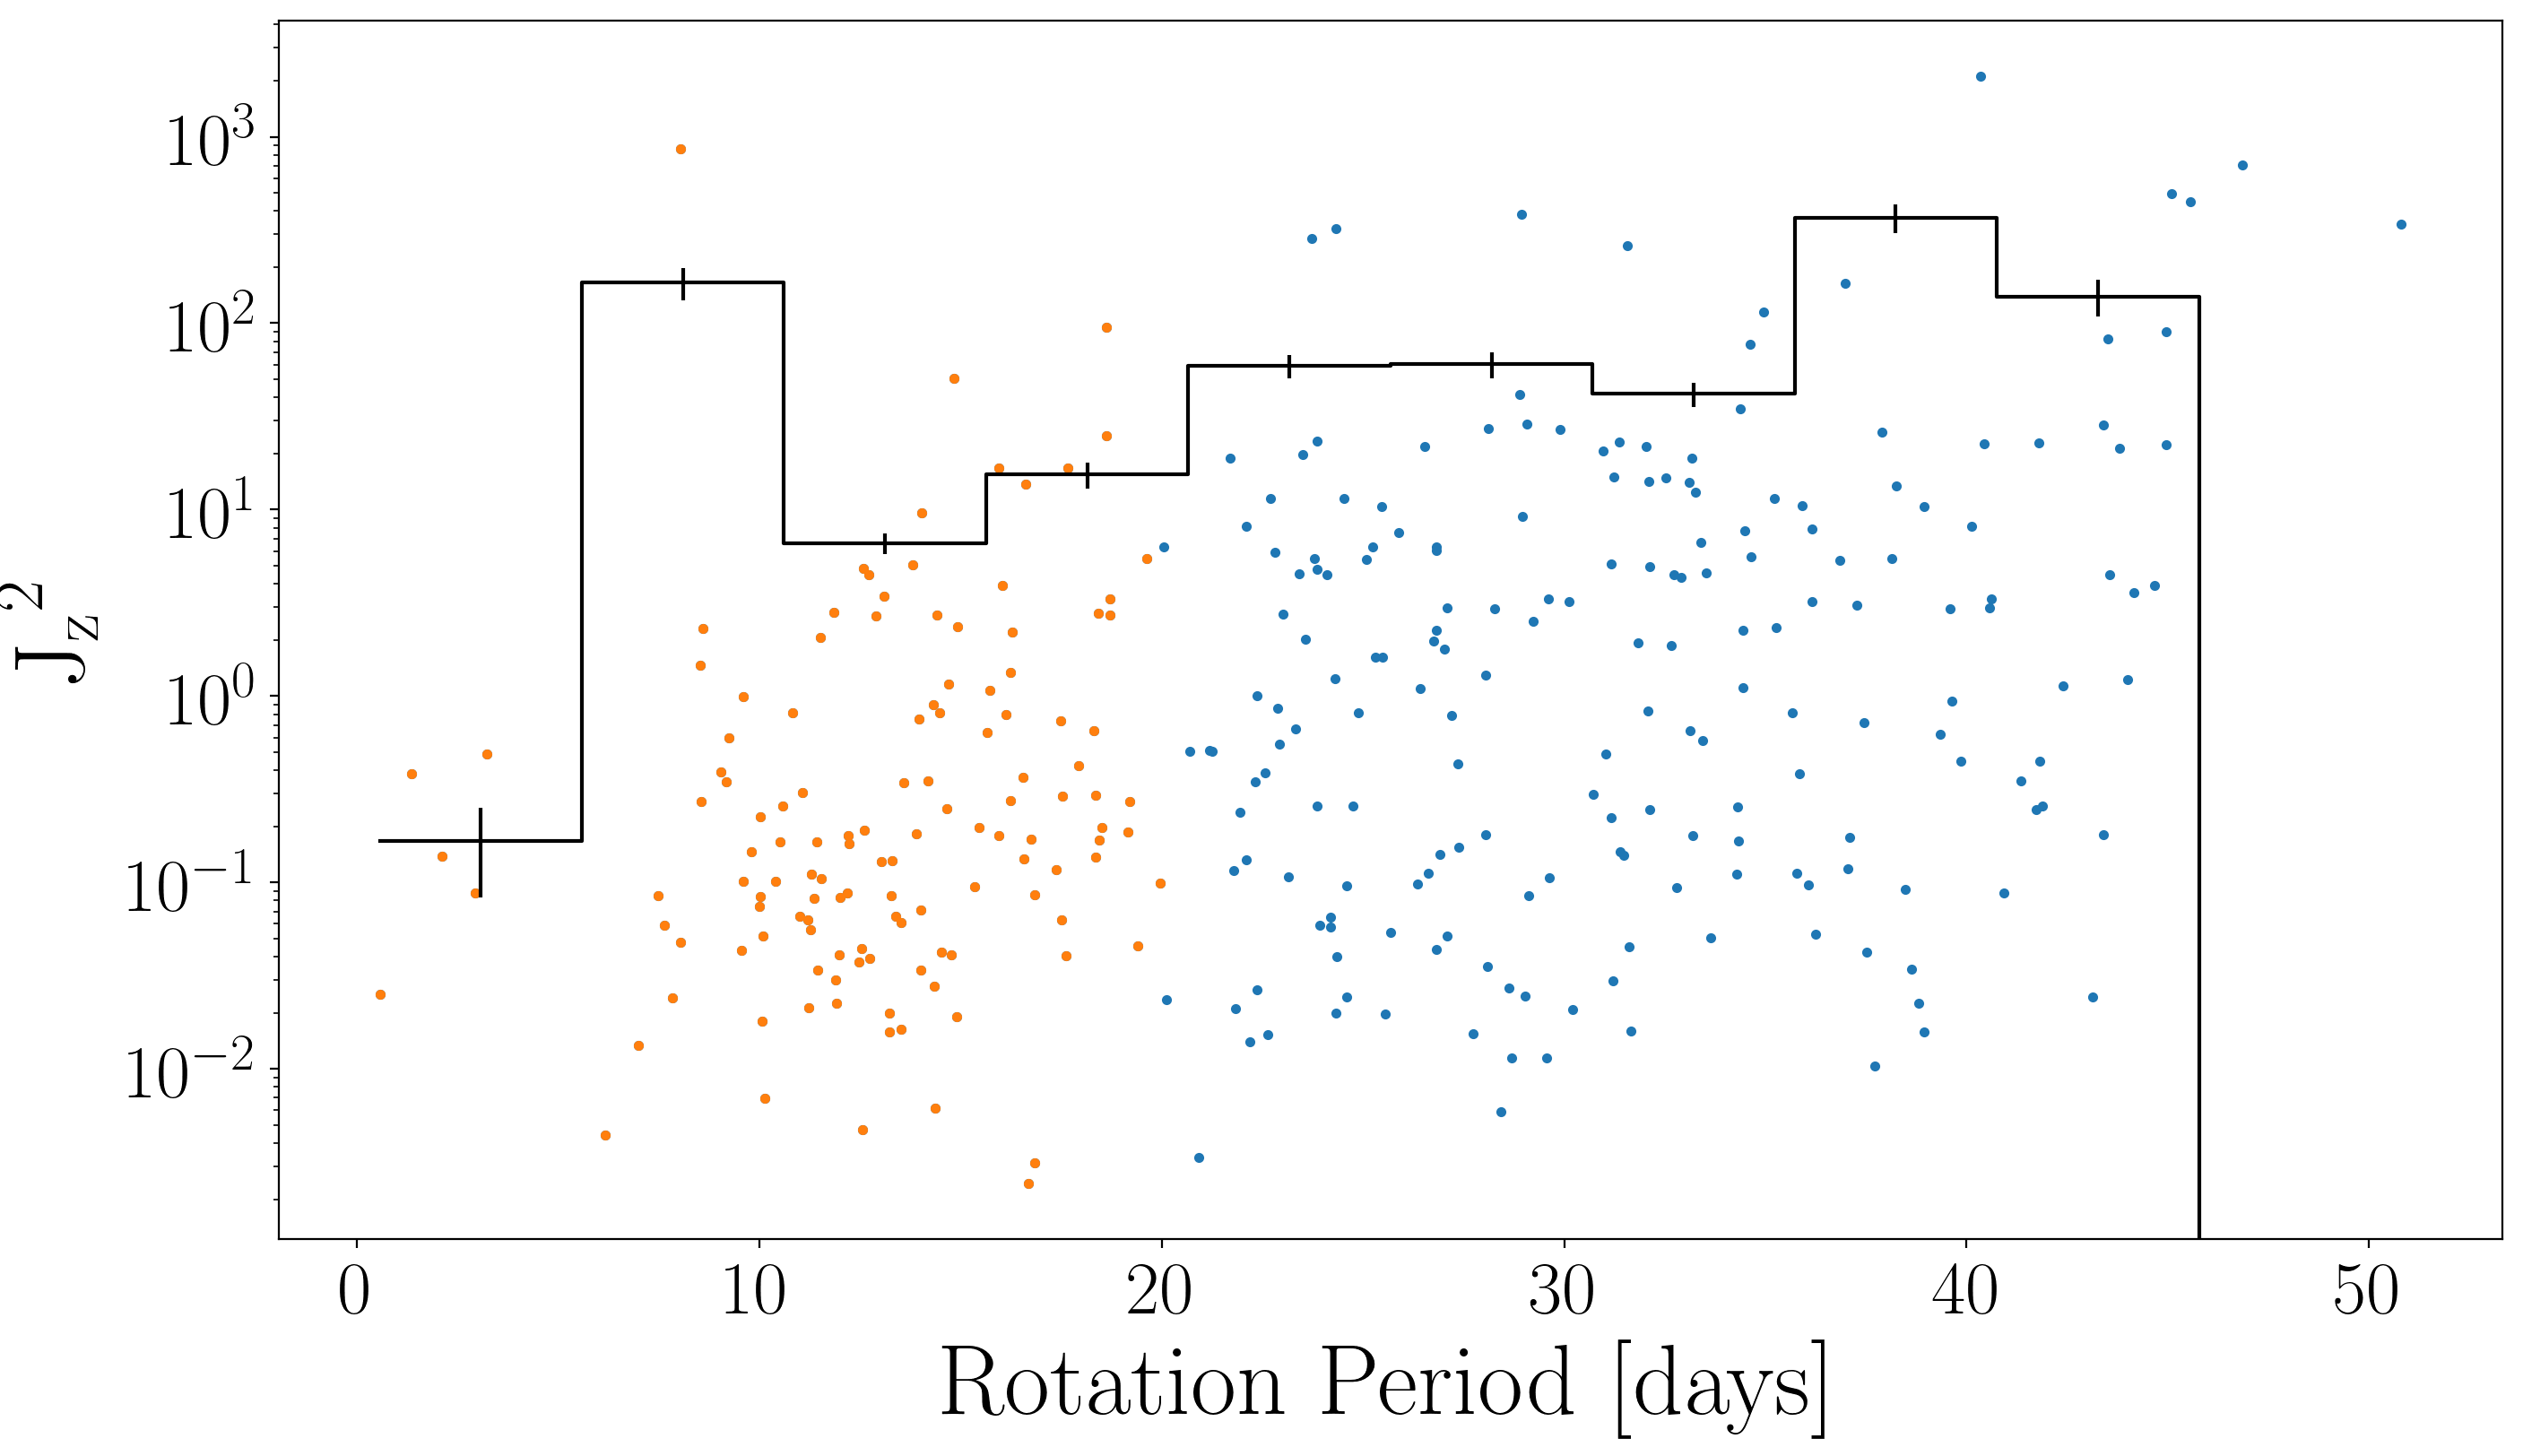

In [178]:
pinds = np.argsort(cool.Prot.values)
p, j = cool.Prot.values[pinds], jz[pinds]**2
newp, dj = running_dispersion(p, j, 50, mad=False)
bins, dbins, err = binned_dispersion(p, j, 10, mad=False)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(cool.Prot.values, jz**2, ".", zorder=0)
m = cool.Prot.values < 20
plt.plot(cool.Prot.values[m], jz[m]**2, ".", zorder=1)
# plt.plot(newp, dj, ".")
plt.step(bins-.5*np.diff(bins)[0], dbins, where="post", color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
plt.yscale("log")
plt.xlabel("$\mathrm{Rotation~Period~[days]}$")
plt.ylabel("$\mathrm{J_z}^2$")
plt.savefig("rotation_action_dispersion.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until

5888


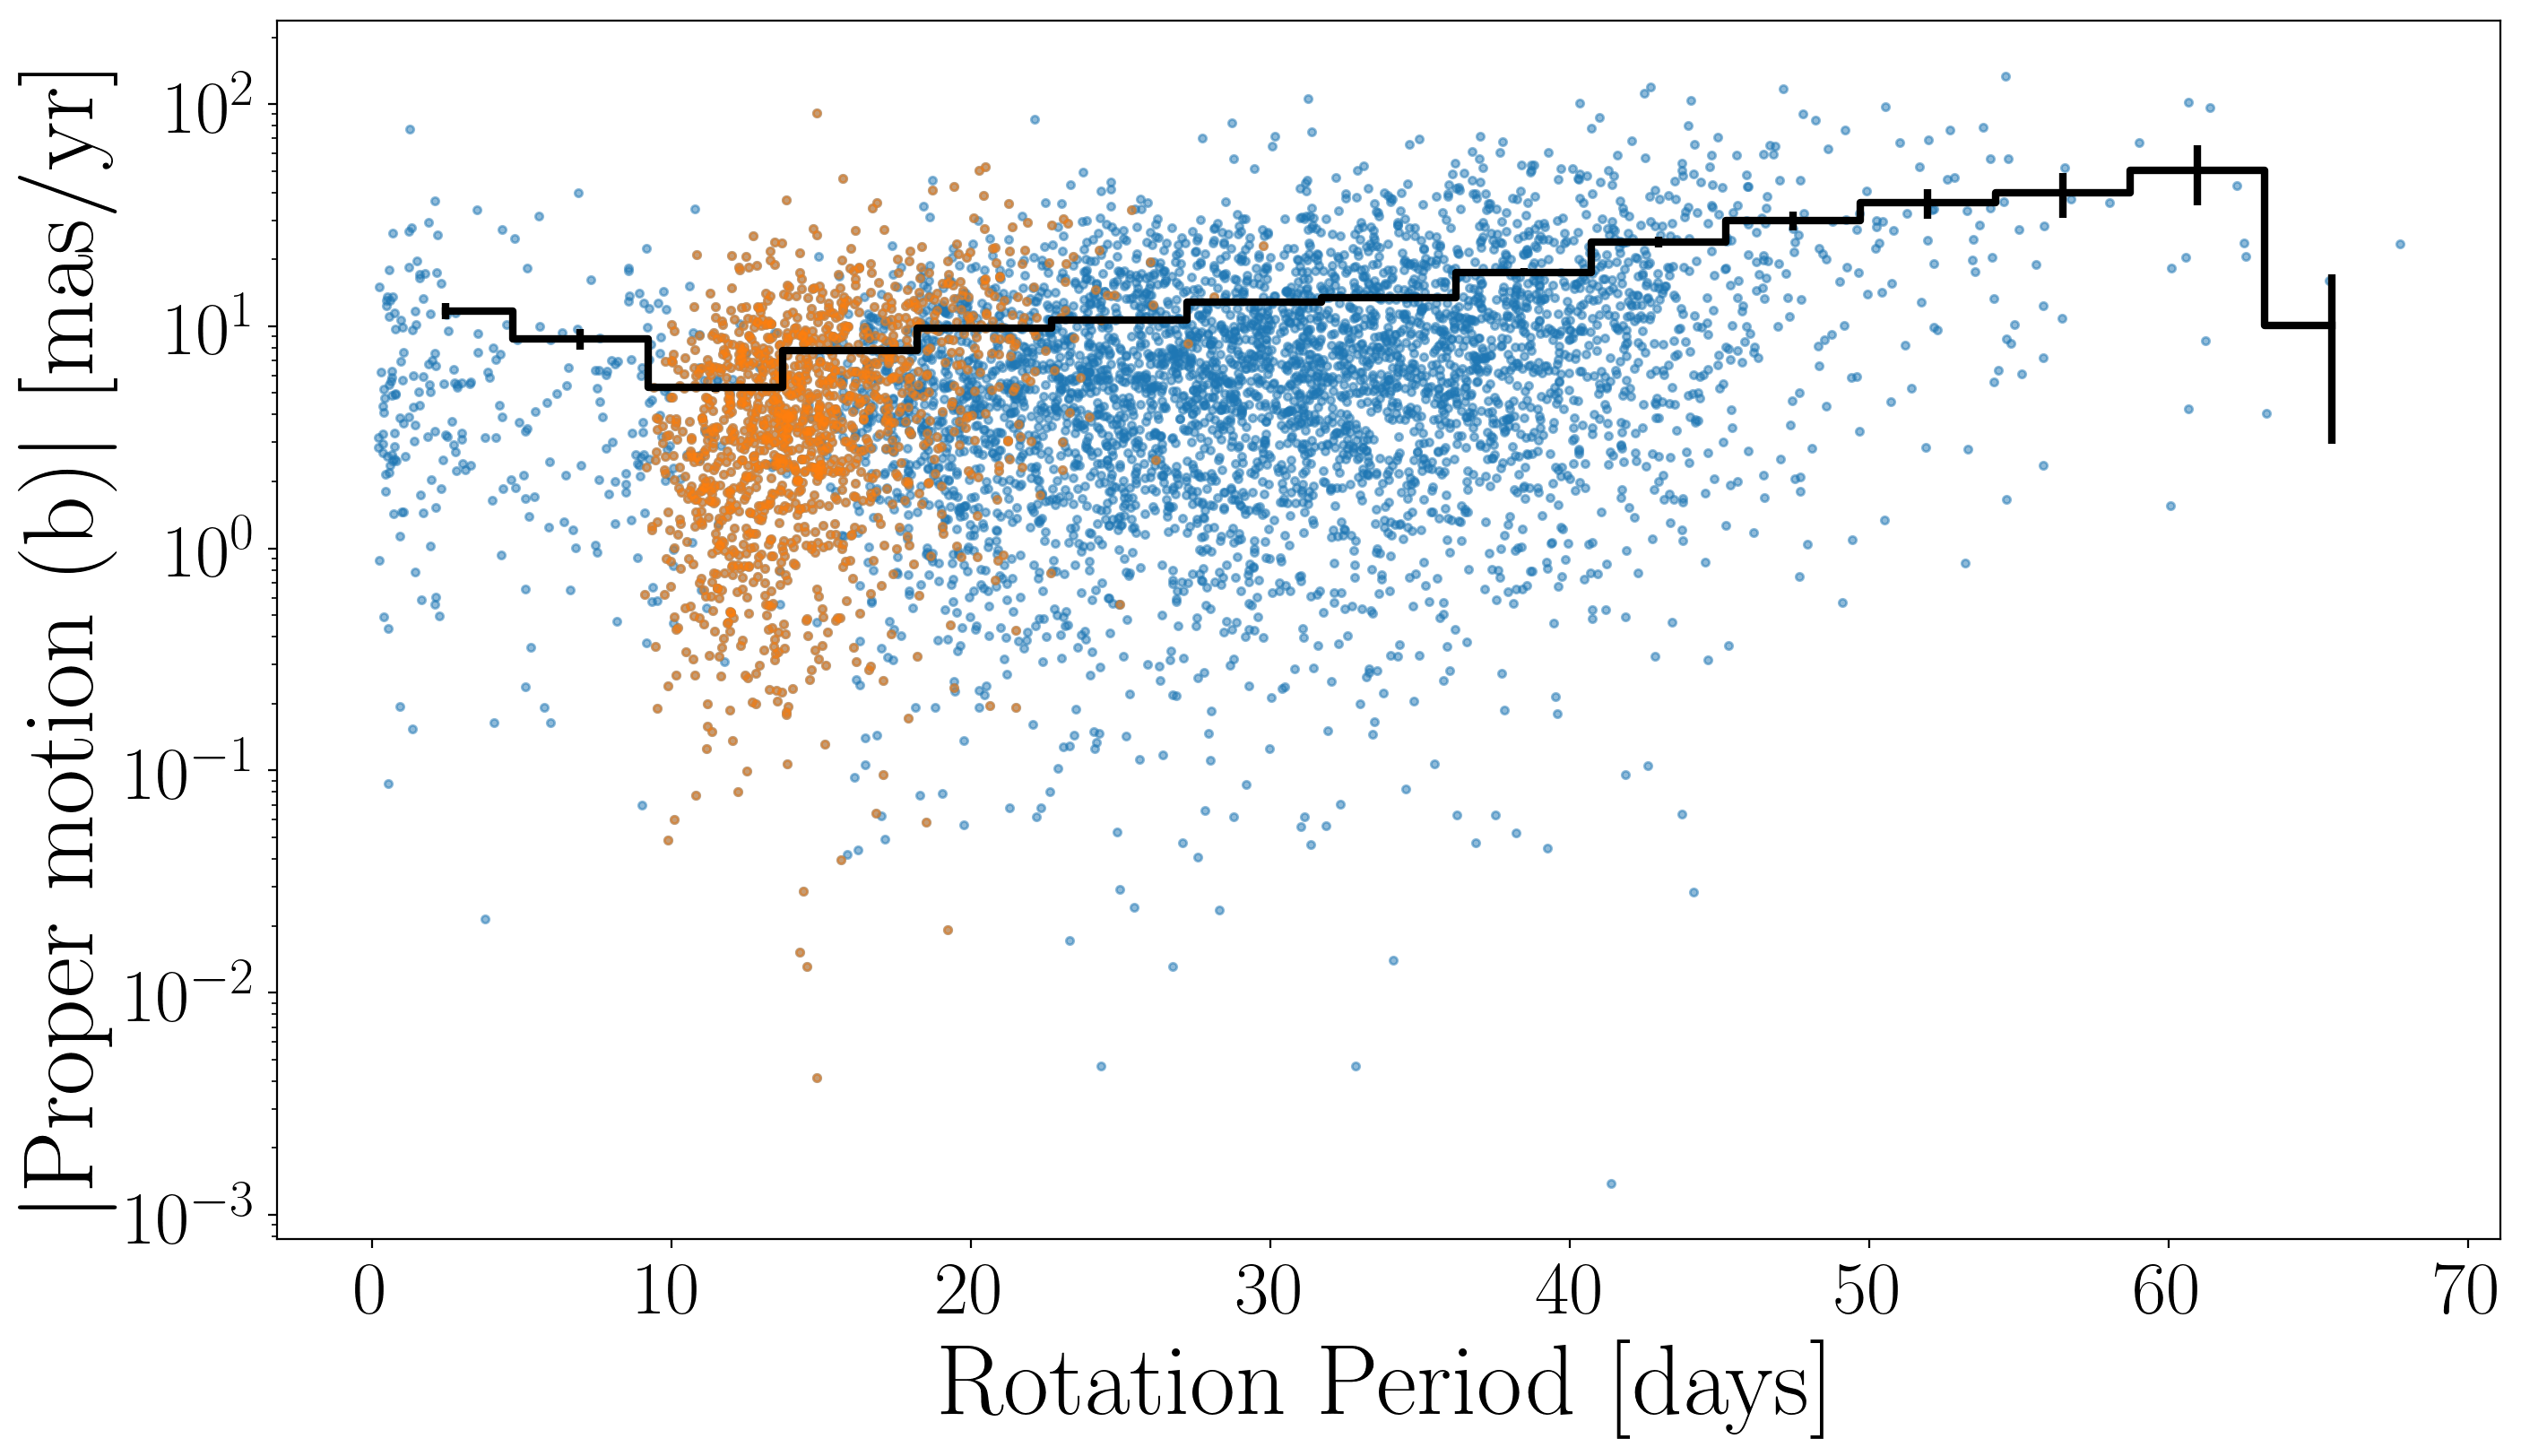

In [179]:
bins, dbins, err = binned_dispersion(gaia_mc_cool.Prot.values, gaia_mc_cool.pm_b.values, 15, mad=False)

age_bracket = (gaia_mc_cool.age.values > .5) * (gaia_mc_cool.age.values < 1.1)

print(len(gaia_mc_cool.Prot.values))
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_mc_cool.Prot.values, abs(gaia_mc_cool.pm_b.values), ".", zorder=0, alpha=.5)
plt.plot(gaia_mc_cool.Prot.values[age_bracket], abs(gaia_mc_cool.pm_b.values[age_bracket]),
         ".", zorder=1, alpha=.5)
plt.step(bins, dbins, where="mid", color="k", lw=3)
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", elinewidth=3, ms=1)
plt.yscale("log")
plt.xlabel("$\mathrm{Rotation~Period~[days]}$")
plt.ylabel("$\mathrm{|Proper~motion~(b)|~[mas/yr]}$")
plt.savefig("rotation_pmb_dispersion.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.



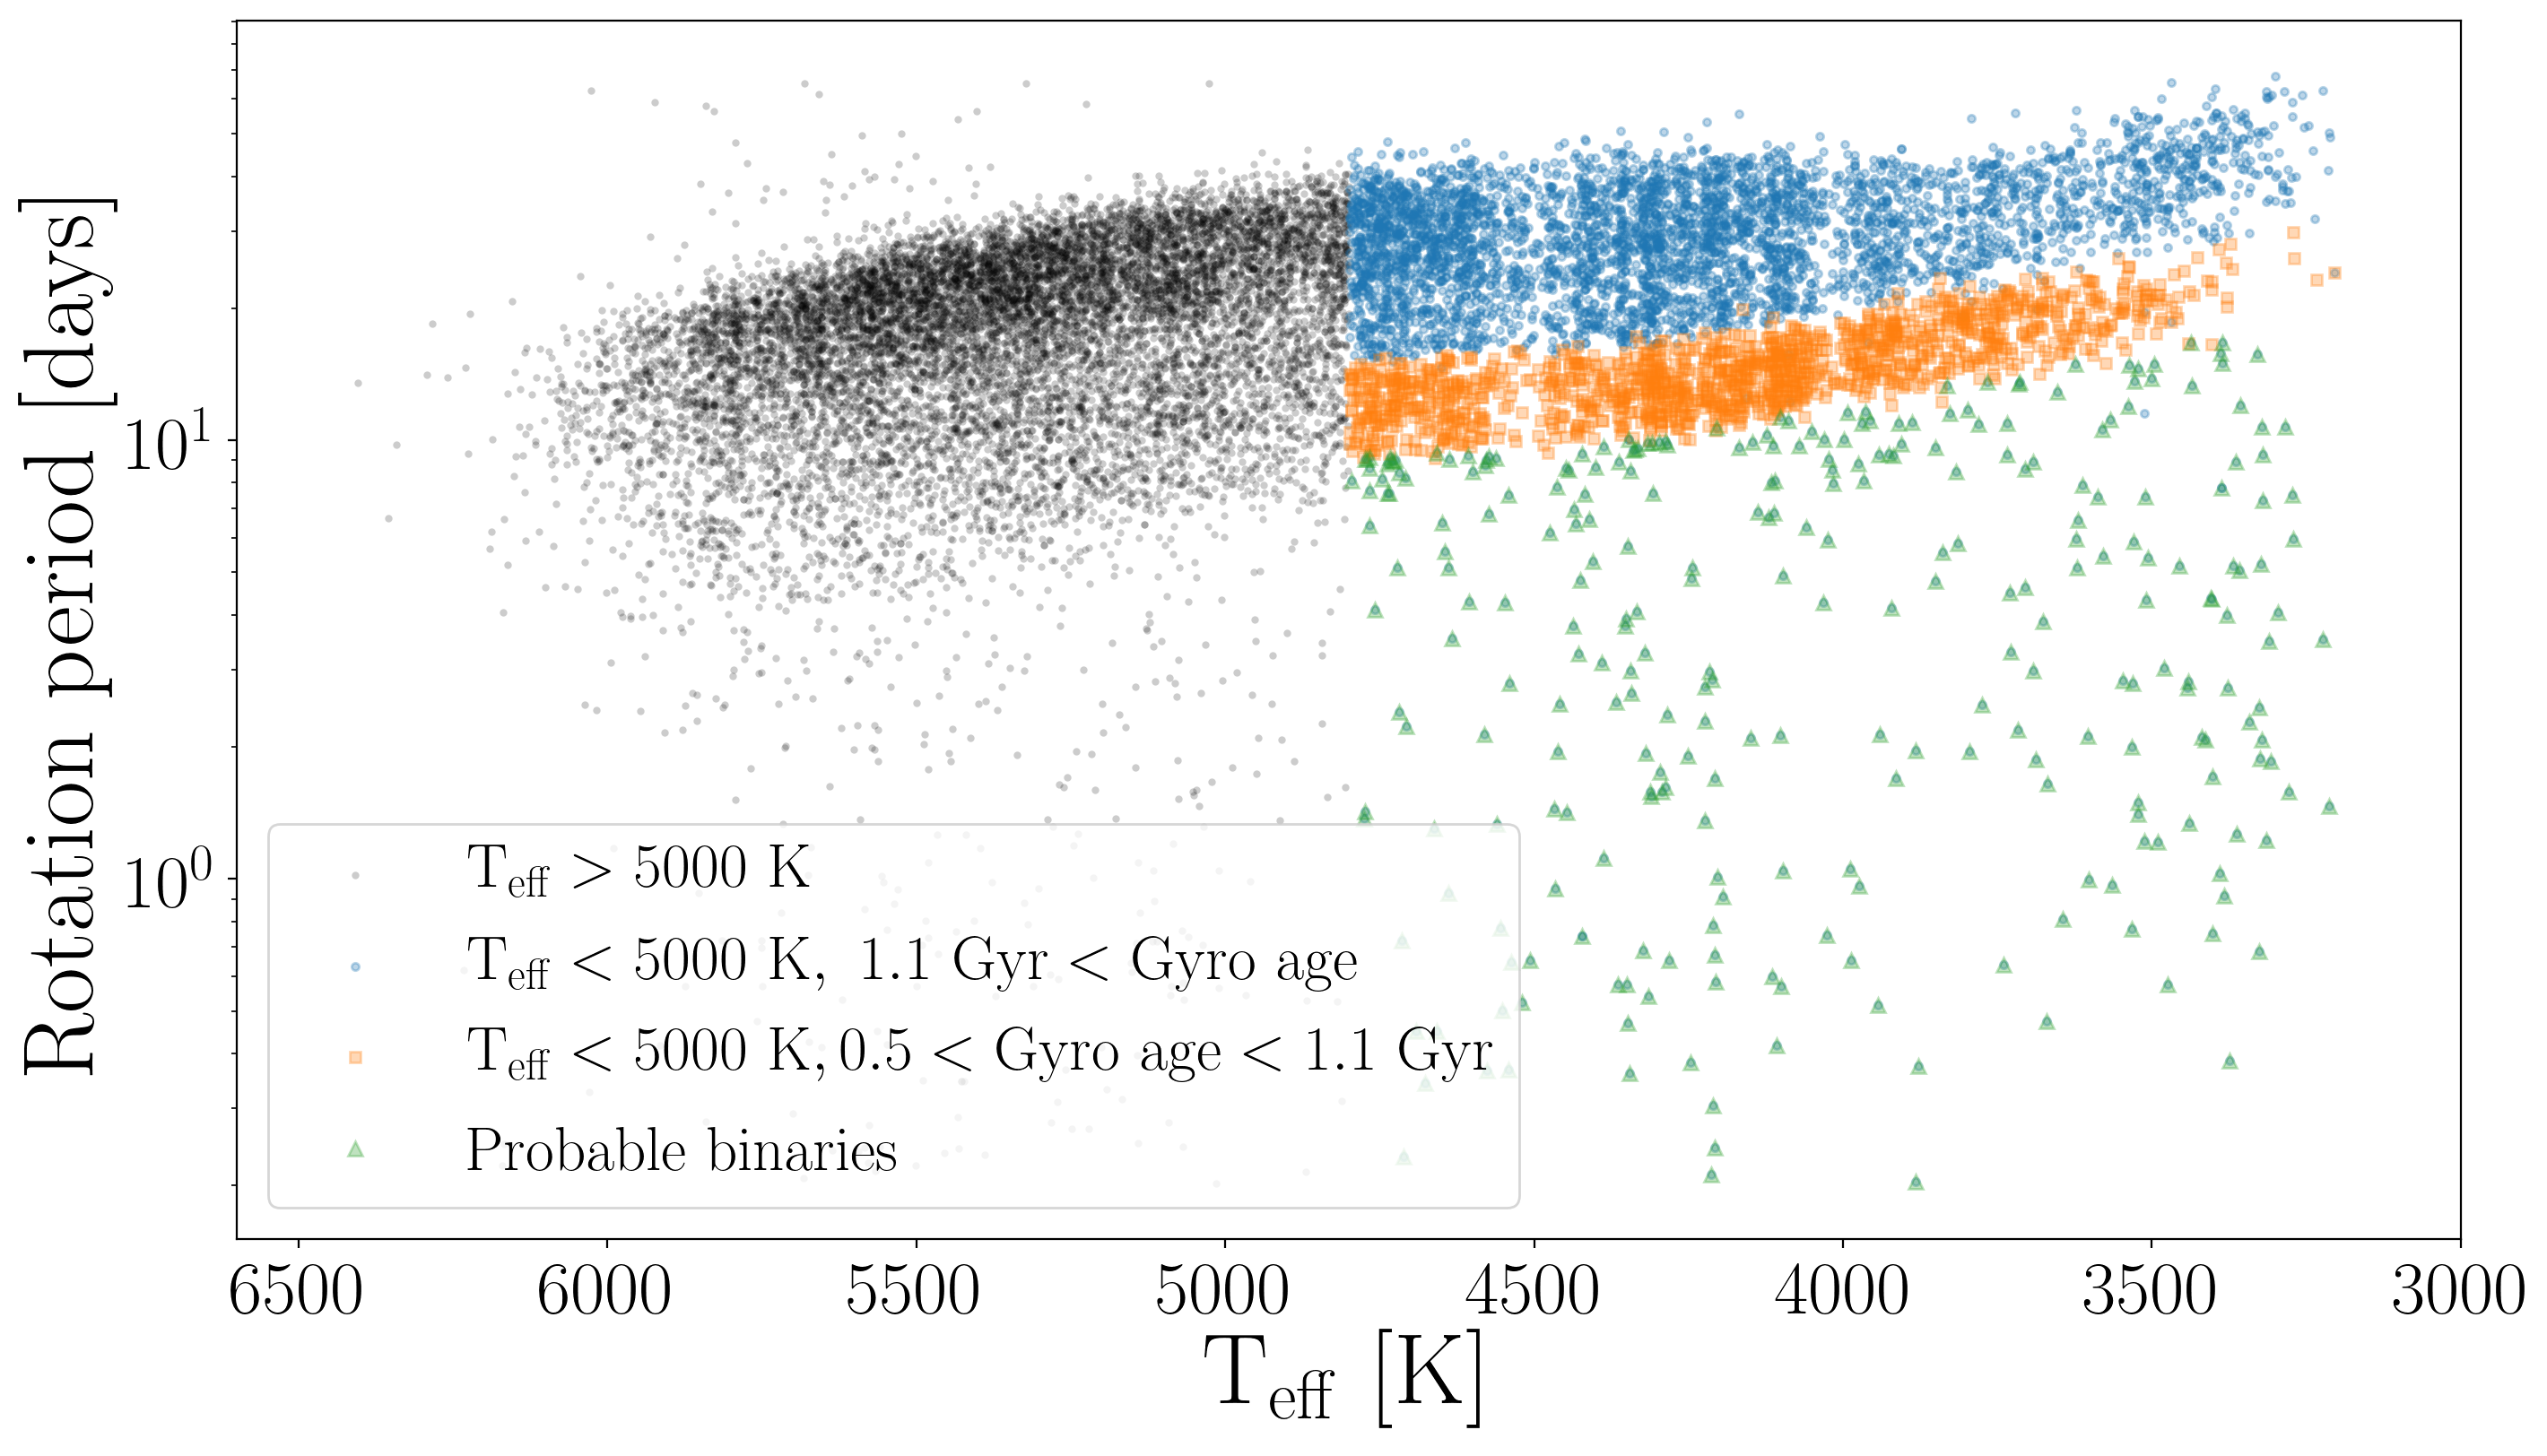

In [229]:
binaries = gaia_mc_cool.age.values < .5

plt.figure(figsize=(16, 9), dpi=200)

# All McQuillan-Gaia stars that are not equal-mass binaries or subgiants.
plt.plot(gaia_mc_hot.Teff, gaia_mc_hot.Prot,
         "k.", zorder=0, alpha=.2, mec="none", label="$\mathrm{T_{eff} > 5000~K}$")

# Cool stars
plt.plot(gaia_mc_cool.Teff.values[~age_bracket], gaia_mc_cool.Prot.values[~age_bracket],
         "o", ms=3, color="C0", zorder=1, alpha=.3,
         label="$\mathrm{T_{eff} < 5000~K,~1.1~Gyr < Gyro~age}$")

# Gap stars
plt.plot(gaia_mc_cool.Teff.values[age_bracket], gaia_mc_cool.Prot.values[age_bracket],
         "s", color="C1", ms=4, zorder=2, alpha=.3,
         label="$\mathrm{T_{eff} < 5000~K, 0.5 < Gyro~age < 1.1~Gyr}$")

# Binaries
plt.plot(gaia_mc_cool.Teff.values[binaries], gaia_mc_cool.Prot.values[binaries],
         "^", color="C2", zorder=2, alpha=.3,
         label="$\mathrm{Probable~binaries}$")

# plt.plot(df.Teff, df.Prot, ".", color="C0", alpha=.99, ms=12, zorder=1)
# plt.plot(cool.Teff, cool.Prot, ".", color="C1", alpha=.99, ms=12, zorder=1)
# plt.plot(cool.Teff[age_bracket], cool.Prot[age_bracket], ".", color="C2", alpha=.99, ms=12, zorder=1)

xs = np.linspace(3500, 5000, 100)
plt.xlim(6600, 3000)
plt.yscale("log")
plt.legend()
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

Plot a zoom-in

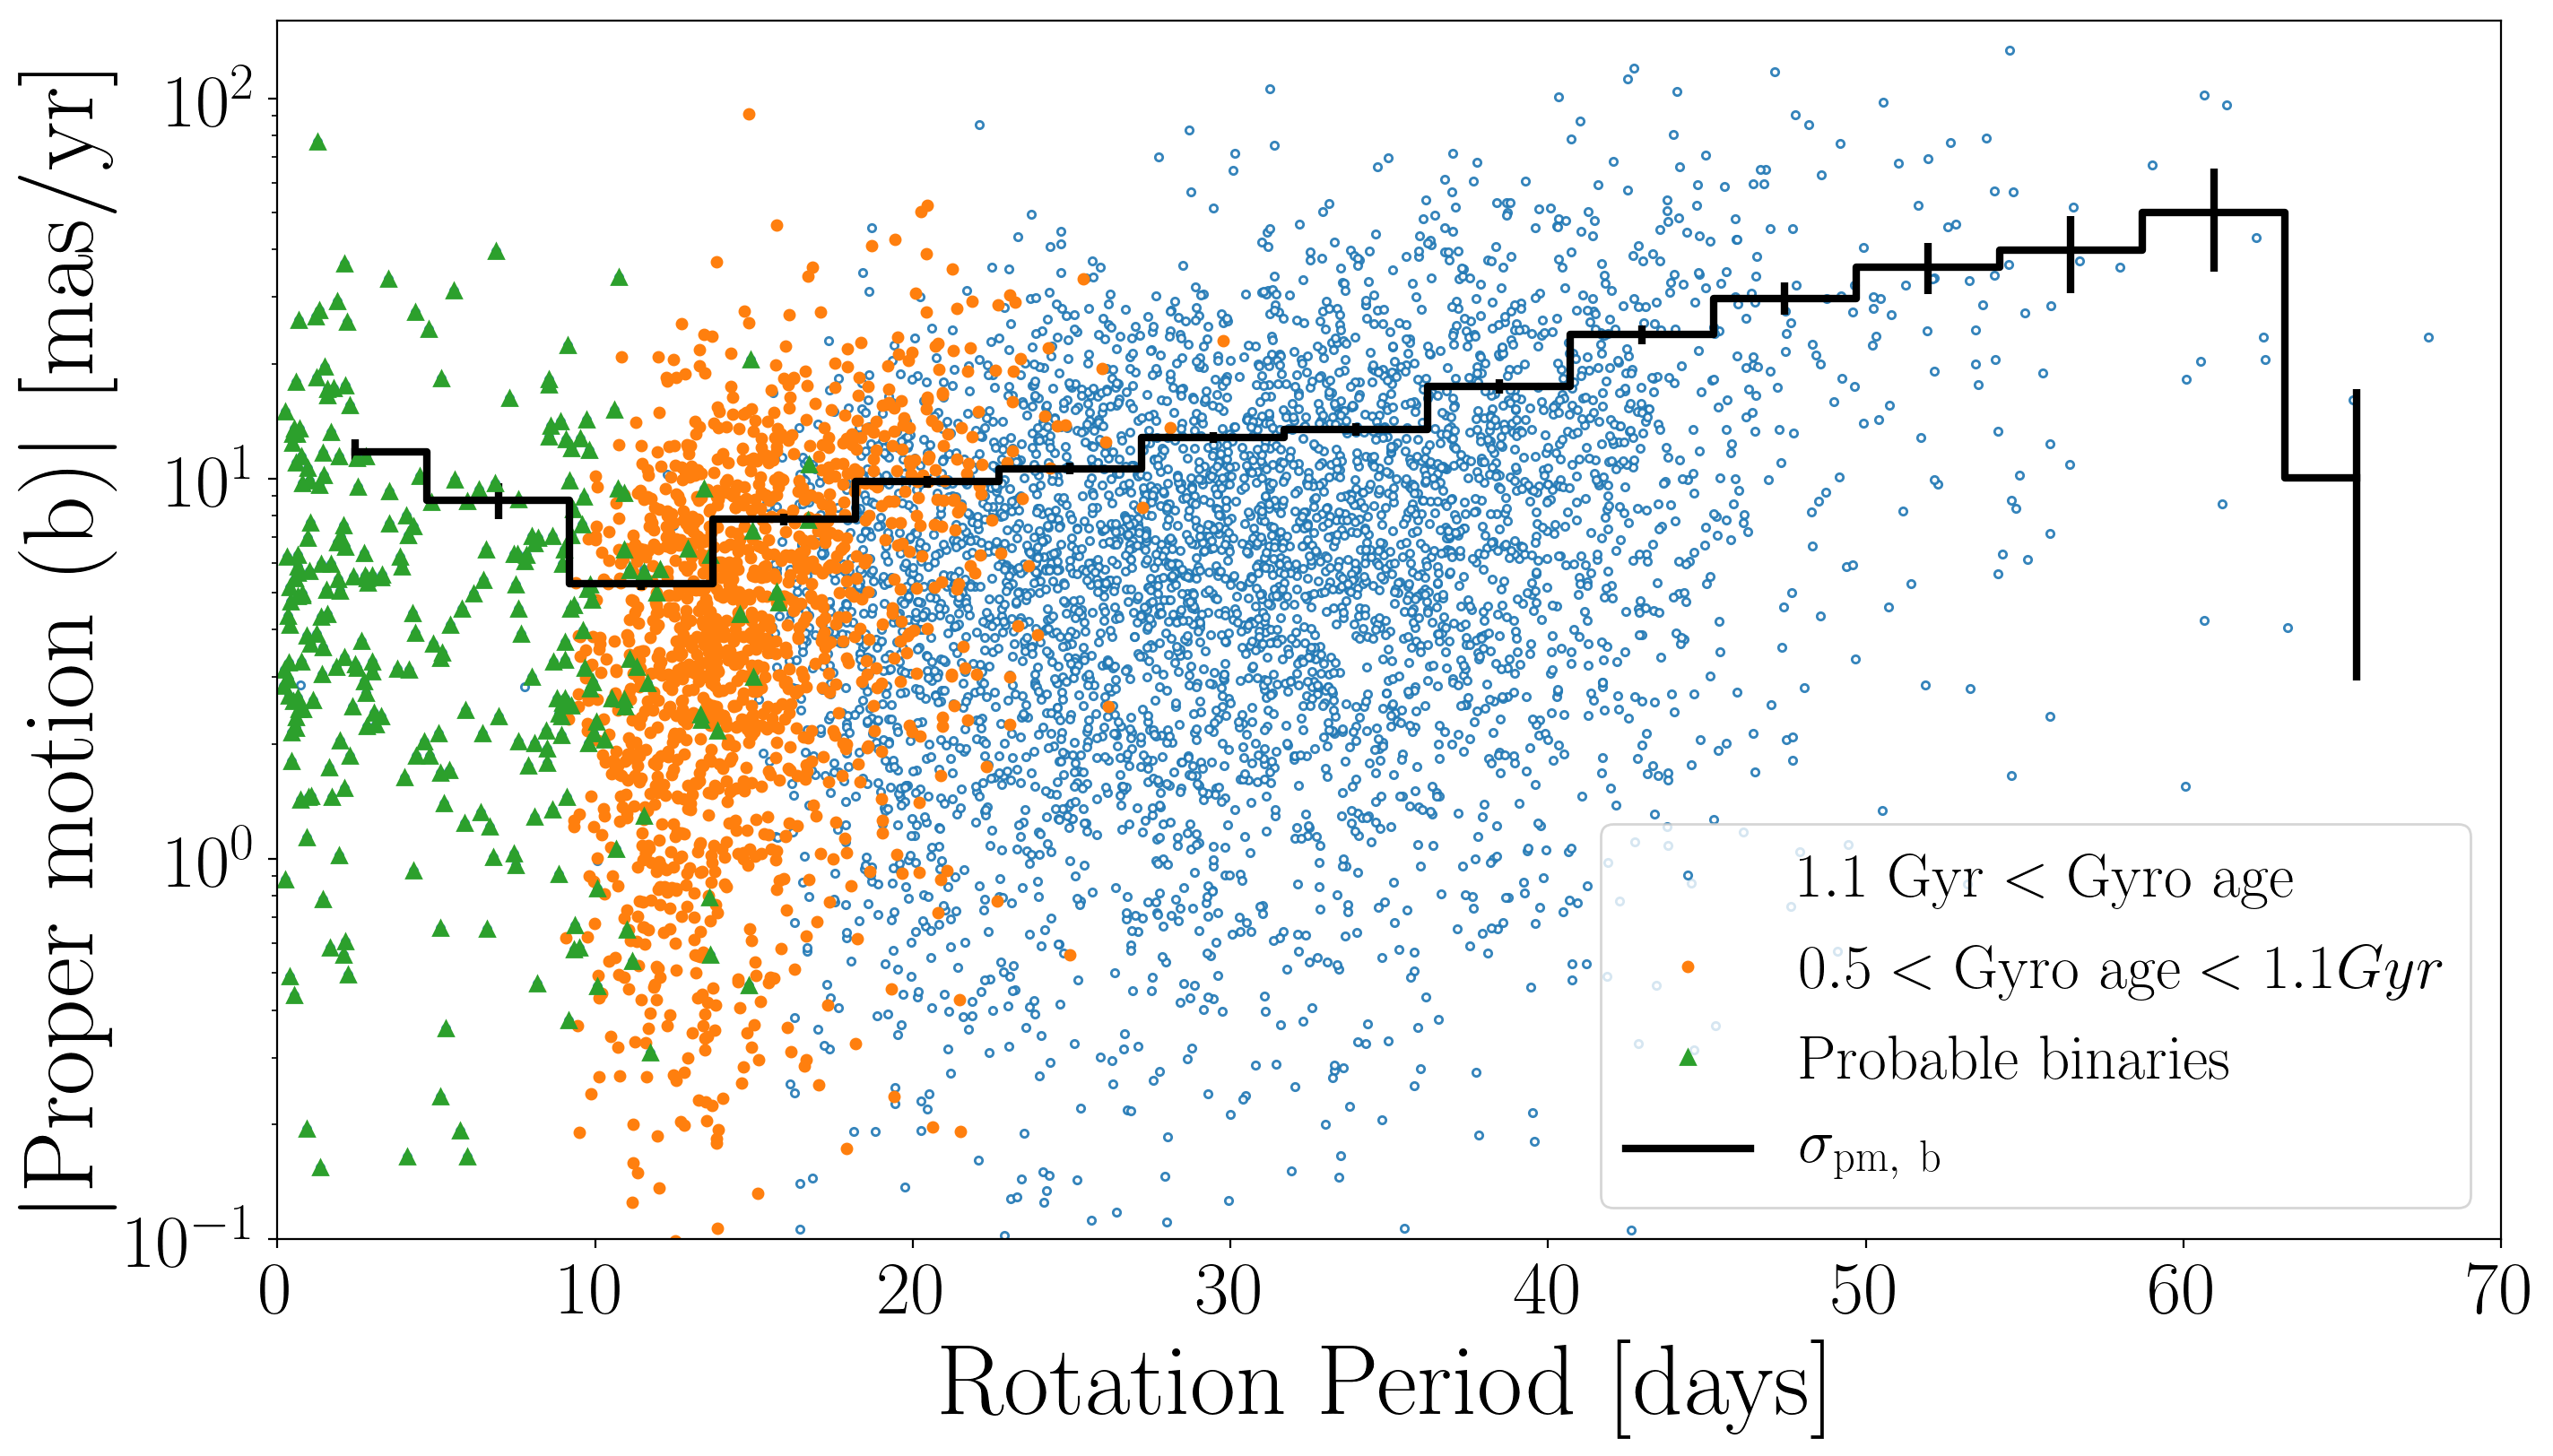

In [210]:
bins, dbins, err = binned_dispersion(gaia_mc_cool.Prot.values, gaia_mc_cool.pm_b.values, 15, mad=False)

plt.figure(figsize=(16, 9), dpi=200)

# Old stars
plt.plot(gaia_mc_cool.Prot.values, abs(gaia_mc_cool.pm_b.values),
         ".", ms=3, color="C0zorder=0, alpha=.9, label="$\mathrm{1.1~Gyr < Gyro~age}$")

# Gap stars
plt.plot(gaia_mc_cool.Prot.values[age_bracket], abs(gaia_mc_cool.pm_b.values[age_bracket]),
         ".", color="C1", ms=8, zorder=1, label="$ 0.5 < \mathrm{Gyro~age} < 1.1 Gyr$")

# Binaries
plt.plot(gaia_mc_cool.Prot.values[binaries], abs(gaia_mc_cool.pm_b.values[binaries]),
         "^", color="C2", zorder=2, label="$\mathrm{Probable~binaries}$")

plt.step(bins, dbins, where="mid", color="k", lw=3, label="$\sigma_{\mathrm{pm,~b}}$")

plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", elinewidth=3, ms=1)
plt.yscale("log")
plt.xlabel("$\mathrm{Rotation~Period~[days]}$")
plt.ylabel("$\mathrm{|Proper~motion~(b)|~[mas/yr]}$")
plt.ylim(.1, 160)
plt.xlim(0, 70)
plt.legend()
# plt.savefig("rotation_pmb_dispersion.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.



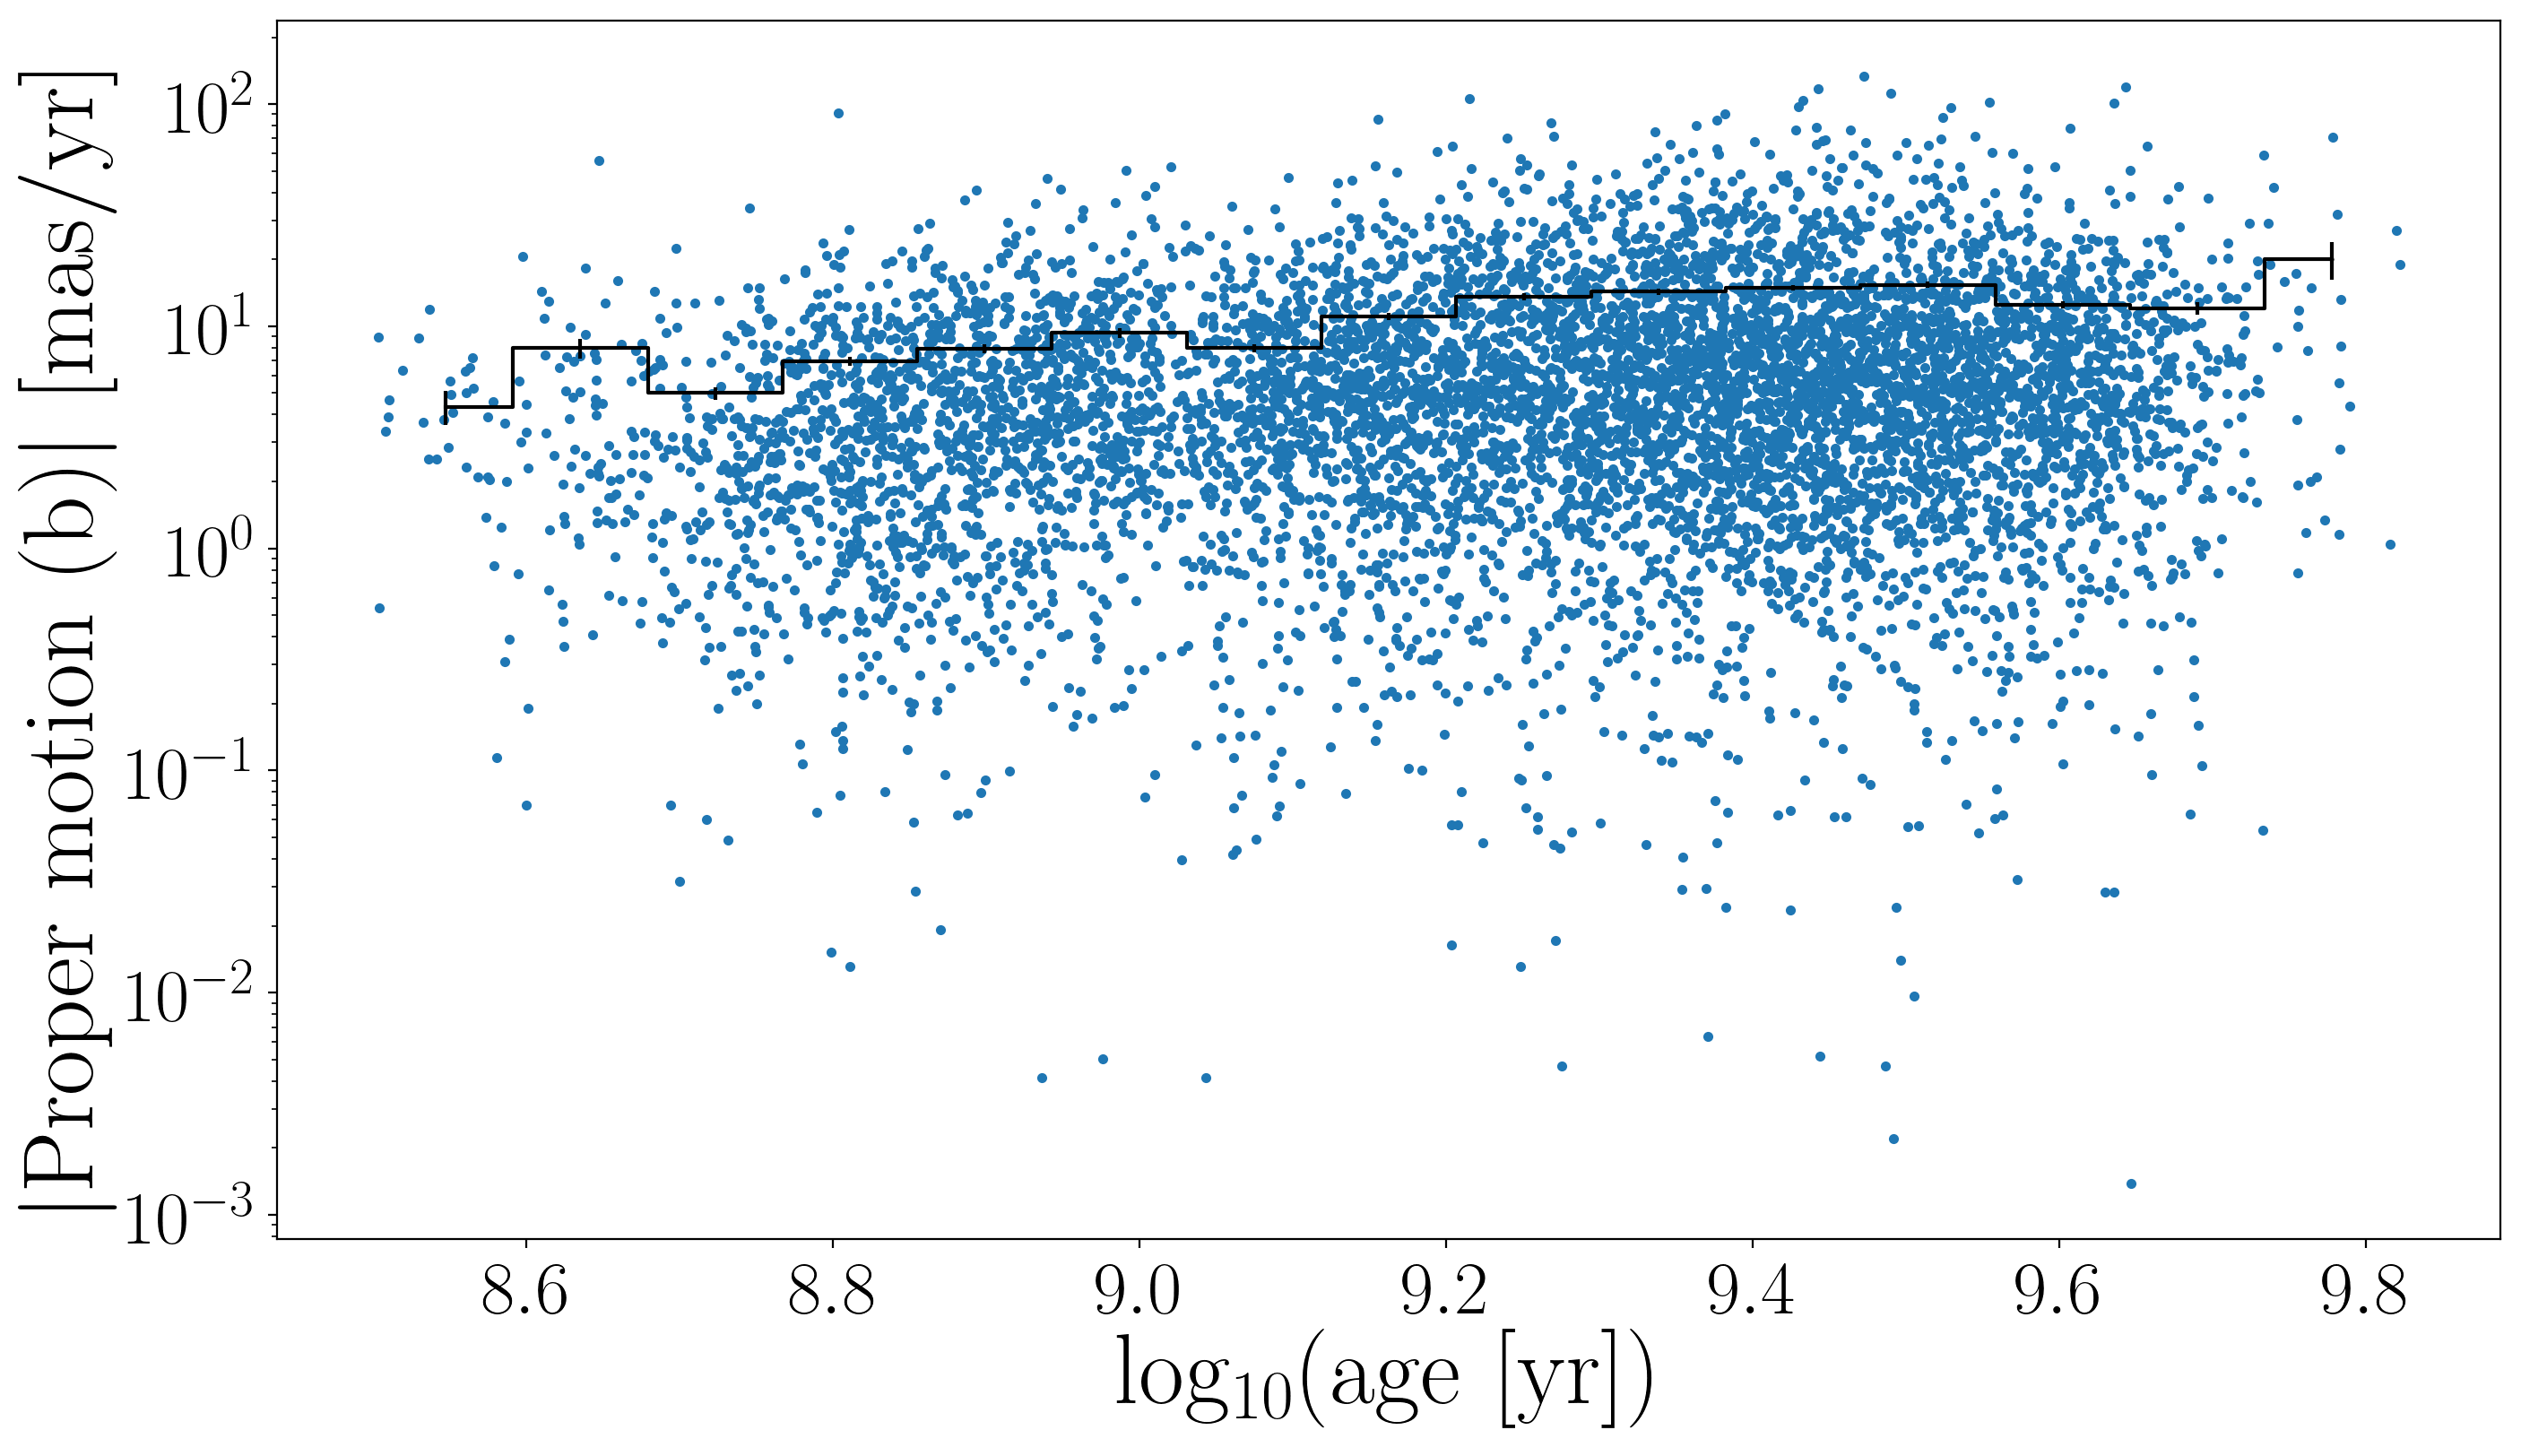

In [150]:
gmc = gaia_mc_cool.iloc[gaia_mc_cool.log_age.values > 8.5]
bins, dbins, err = binned_dispersion(gmc.log_age.values, gmc.pm_b.values, 15, mad=False)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gmc.log_age.values, abs(gmc.pm_b.values), ".", zorder=0)
plt.step(bins, dbins, where="mid", color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
plt.yscale("log")
plt.xlabel("$\mathrm{log_{10}(age~[yr])}$")
plt.ylabel("$\mathrm{|Proper~motion~(b)|~[mas/yr]}$")
plt.savefig("rotation_pmb_dispersion.pdf")

# print(len(cool.Prot.values), len(cool.pm_b.values),
#       sum(np.isfinite(cool.Prot.values)), sum(np.isfinite(cool.pm_b.values)))
# print(cool.pm_b.values)

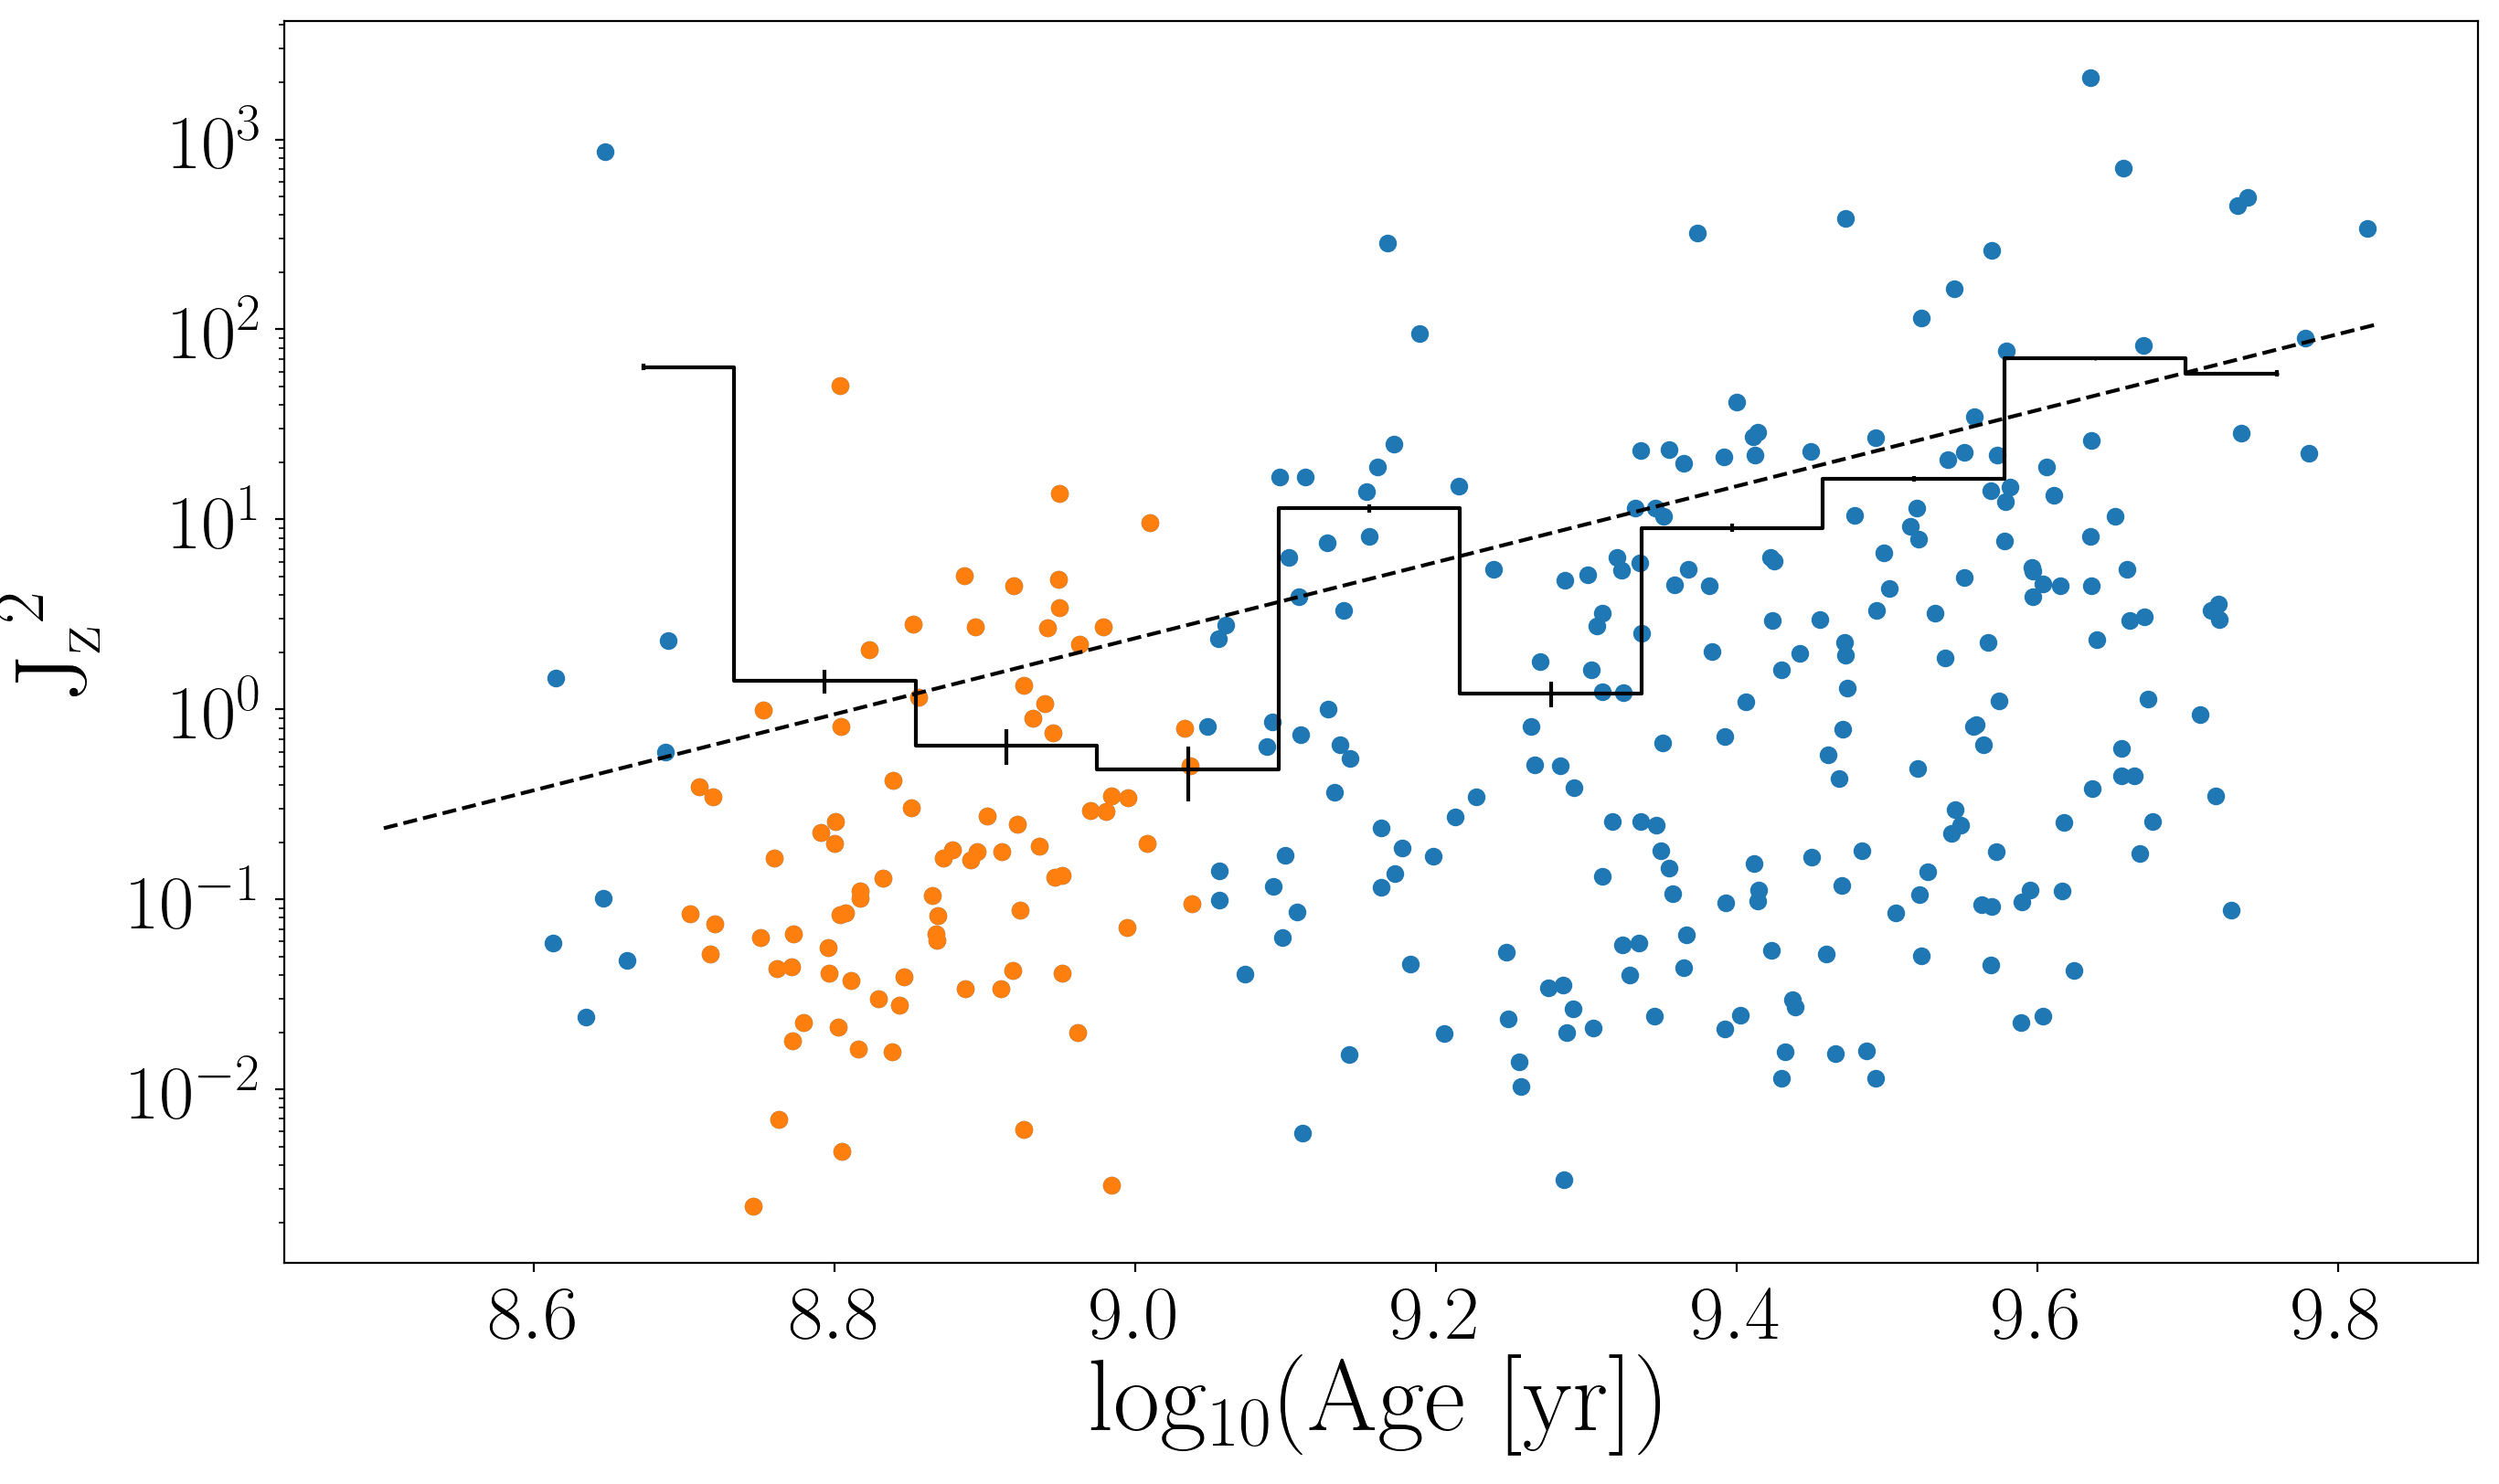

In [53]:
m = (.4 < cool.age)
bins, dbins, err = binned_dispersion(cool.log_age[m], cool.jz[m], 10, mad=False)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(cool.log_age[m], cool.jz[m]**2, ".", ms=12, color="C0", zorder=0)#, label="$\mathrm{P_{rot} > 20}$")

age_line = np.log10(1.1*1e9)
mb = (cool.log_age < age_line) * (.5 < cool.age)
plt.plot(cool.log_age[mb], cool.jz[mb]**2, ".", ms=12, color="C1", zorder=1)#, label="$\mathrm{P_{rot} < 20}$")

plt.yscale("log")
plt.step(bins, dbins**2, where="mid", color="k")
plt.errorbar(bins, dbins**2, yerr=err, fmt=".", color="k", ms=1)
plt.xlabel("$\mathrm{log_{10}(Age~[yr])}$")
plt.ylabel("$\mathrm{J_z}^2$")
xs = np.linspace(8.5, max(ages), 1000)
linx = (10**xs)*1e-9
model_jz_dispersion = linx*1.54
plt.plot(xs, (linx*1.54)**2, "k--", label="$\mathrm{Beane,~Ness~\&~Bedell~(2018)}$")
# plt.legend()
plt.subplots_adjust(left=.15)
plt.savefig("ages_actions")

(1, 200)

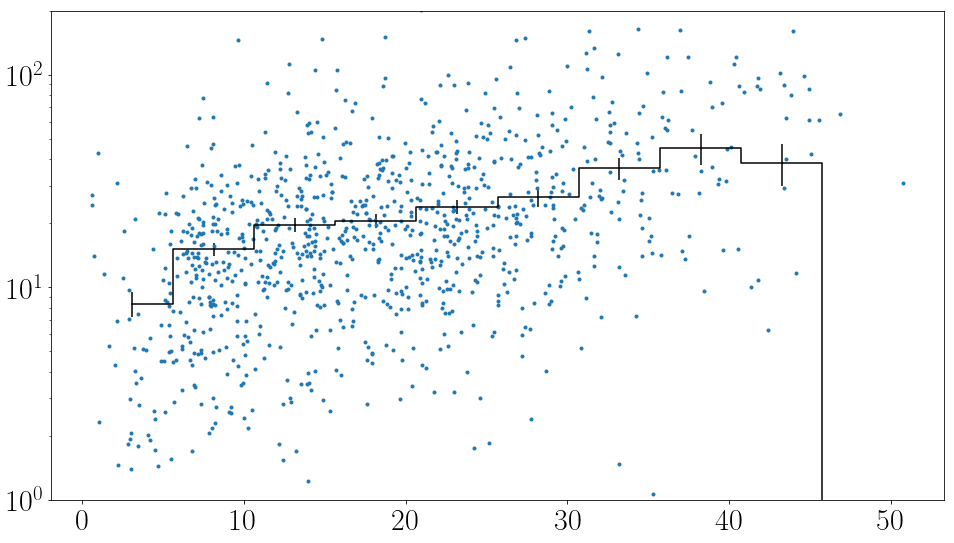

In [71]:
bins, dbins, err = binned_dispersion(df.Prot, np.sqrt(df.pmra**2 + df.pmdec**2), 10, mad=False)

plt.figure(figsize=(16, 9))
plt.plot(df.Prot, np.sqrt(df.pmra**2 + df.pmdec**2), ".")
plt.step(bins, dbins, where="mid", color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)

plt.yscale("log")
# plt.xlim(8.2, 10)
plt.ylim(1, 200)

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



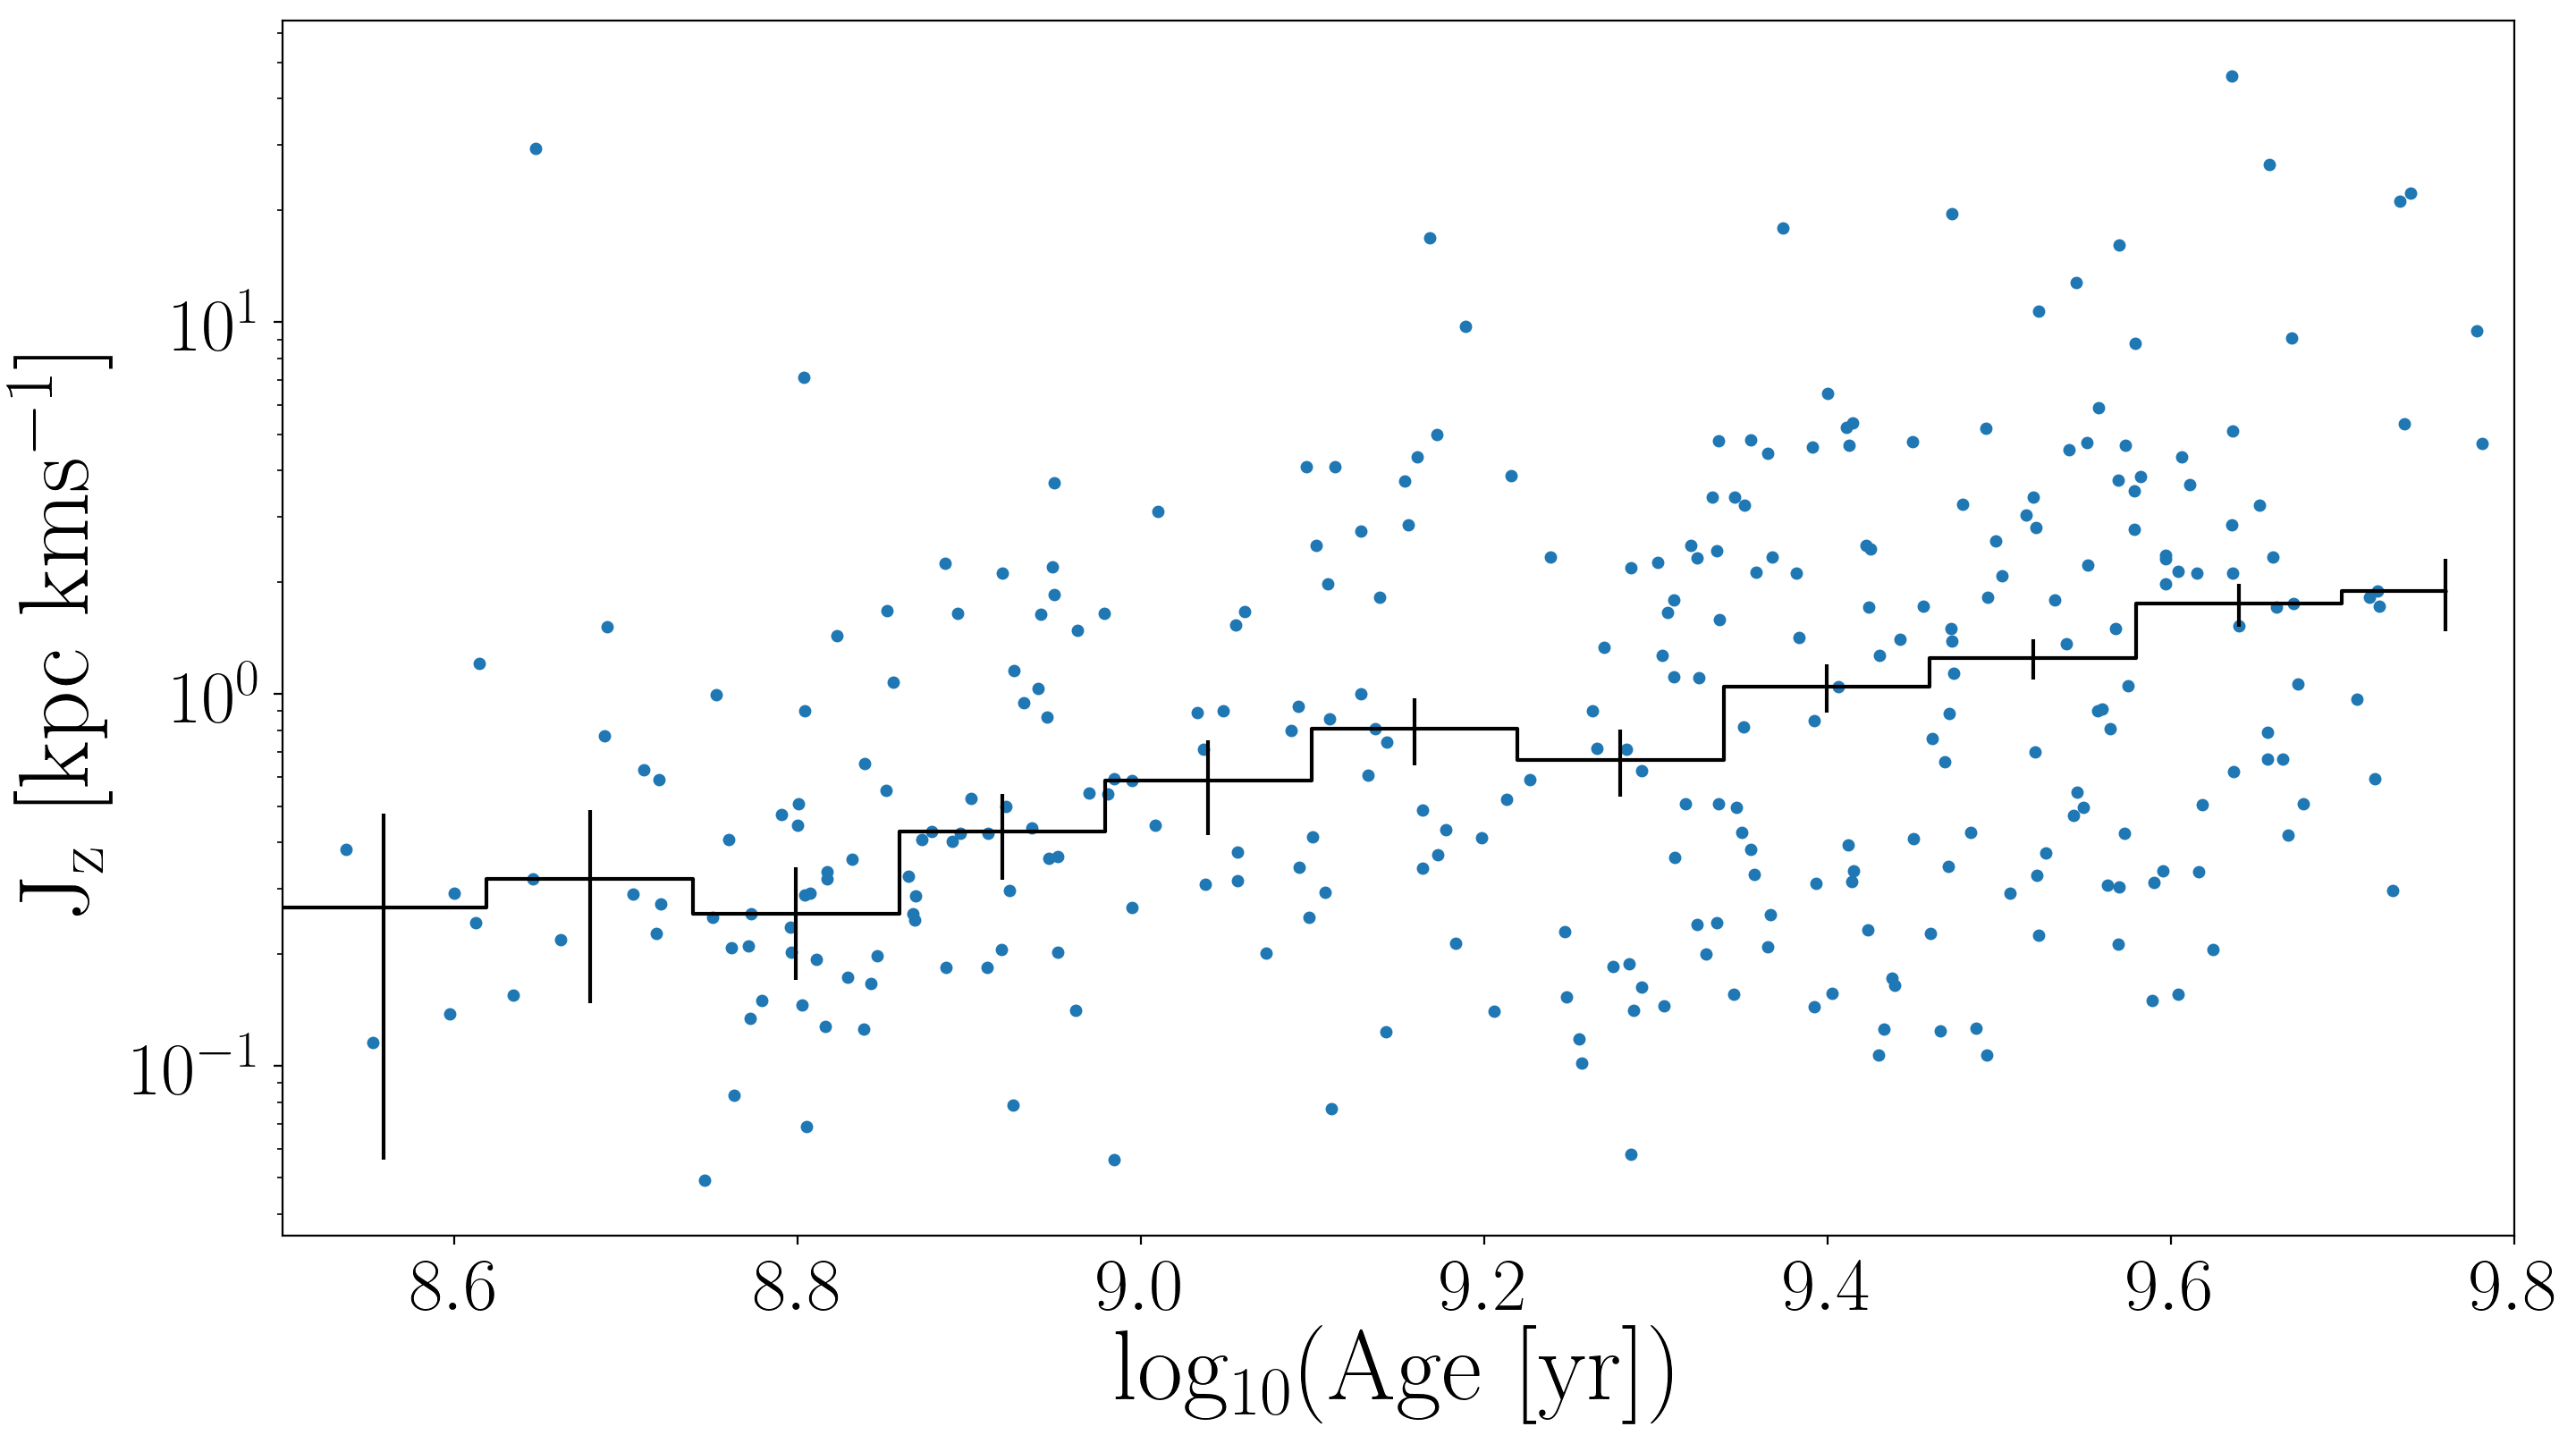

In [94]:
bins, dbins, err = binned_dispersion(cool.log_age, cool.jz, 25, mad=True)

plt.figure(figsize=(16, 9), dpi=200)
plt.yscale("log")
plt.plot(cool.log_age, abs(cool.jz), ".", ms=8, color="C0", zorder=0)#, label="$\mathrm{P_{rot} > 20}$")
plt.step(bins, dbins**2, where="mid", color="k", label="$\mathrm{Median~Absolute~Deviation}$")
plt.errorbar(bins, dbins**2, yerr=err, fmt=".", color="k", ms=1)
# plt.legend(loc="lower right")
plt.xlabel("$\mathrm{log_{10}(Age~[yr])}$")
plt.ylabel("$\mathrm{J_z~[kpc~kms^{-1}]}$")
plt.subplots_adjust(left=.12)
# plt.axvline(age_line, color="k", linestyle="--")
plt.xlim(8.5, 9.8)
plt.savefig("ages_actions")

1) Actually fit the variance
2) Calculate actions with uncertainties
3) Find the line of constant Rossby number/age. (Just plot a gyrochrone of the right age). 